# Fitting Latest Data and Providing Future Estimates

The following consists of a fit to Danish Covid-19 test data, with the aim of determining most precisely the picture for the coming months time.

The fit determins the parameters of the current situation, that is the number of daily positives $P_i$, which is scaled in relation to the number of daily tests $T_i$ as $(T_i/\bar{T})^{-\gamma}$ where $\gamma \sim 0.5-0.7$ (determined by MeasuringTestScalingExponent.ipynb), as the number of positives does not grow linearly with number of tests. From this fit one can also extract the contact number and possibly changes in it, when restrictions change. Based on the lockdown from the beginning of the year until 8th of February, the fit assumes an unchanged contact number for this period.

The fit model to the Scaled Positives is: $SP(t) = SP(t_0) ~ R^{(t-t_0)/t_G}$, where $t_G = 4.7$ days.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
import scipy 
import scipy.stats
from scipy import stats
import iminuit
from iminuit import Minuit

mpl.rcParams['font.size'] = 18      # Set the general plotting font size
plt.rc("font", family="serif")
#plt.rc("text", usetex=True)

save_plots = True
fit_to_latest = True

***

# Read the data:

In [2]:
# data_posi = pd.read_csv("Data-Epidemiologiske-Rapport-19032021-j3k4/Municipality_cases_time_series.csv", sep=';', thousands='.', index_col=0)
# data_test = pd.read_csv("Data-Epidemiologiske-Rapport-19032021-j3k4/Municipality_tested_persons_time_series.csv", sep=';', thousands='.', index_col=0)

data_posi = pd.read_csv("../Data-Epidemiologiske-Rapport-24032021-6m2k/Municipality_cases_time_series.csv", sep=';', thousands='.', index_col=0)
data_test = pd.read_csv("../Data-Epidemiologiske-Rapport-24032021-6m2k/Municipality_tested_persons_time_series.csv", sep=';', thousands='.', index_col=0)

# Print how much data is included:
date_start = "2021-01-01"            # This is thus day 0
if fit_to_latest :
    date_end = data_test.index[-3]   # Omitting the very latest data point (with ~0 statistics)
else :
    date_end = "2021-03-06"          # Value in latest report files
print("  Data used: ", date_start, "-", date_end)    

# Number of Positives (P) and Tests (T) for all of Denmark ("all")
P_all = data_posi.loc[date_start:date_end].sum(axis=1)
eP_all = np.sqrt(P_all)
T_all = data_test.loc[date_start:date_end].sum(axis=1)
eT_all = np.sqrt(T_all)

  Data used:  2021-01-01 - 2021-04-04


---

# Scale and correct the data:

### Define the constants to be used:

The generation time is fixed (from other sources), while the power $\gamma$, the weekly correction factor, and the systematic uncertainties are obtained from the script "Measuring Test Scaling Exponent".

* The average time between generations has been estimated to be $t_G = 4.7$ days.
* The power $\gamma$ to be used in the scaling with number of tested is chosen to be $\gamma = -0.6$.
* The (multiplicative) weekly fluctuations are a further correction.
* The (multiplicative) systematic uncertainty to apply in order to get a decent Chi2 is so far zero. 

In [3]:
# Average time between generations (in days):
tG = 4.7

# Number of positive tests and uncertainty, assuming fixed number of daily tests and power law correction:
Power = -0.50

# Correct for effects of weekdays, corrects from 2nd January forward:
frac = [0.068, 0.096, 0.036, -0.075, -0.115, 0.012, 0.003]    # Based on 1st of January to 15th of February
frac_fra_lørdag = np.roll(frac, -4)    # This corresponds to 1st of January being a Friday (=4)

# To account for larger uncertainties in positives in data than simply the statistical:
SystError = 0.0                      # Should be included at some point
SystErrorScale = 1.0                 # 1.0 (i.e. doubling of error) works OK!

# Fitting function for fraction B117:
t0_B117fit  = 35.0        # t0 is 2021-02-04
frac_t0     = 0.255       # +- 0.008   
tau_B117    = 12.19       # +- 0.40
factor_B117 = np.e**(tG/tau_B117)     # = 1.47. Thus B117 is a factor 1.47 more infectious

def func_fB117(t, frac_t0, tau) :
    return frac_t0*np.exp((t-t0_B117fit)/tau) / ((1-frac_t0) + frac_t0*np.exp((t-t0_B117fit)/tau))

### Calculated the scaled and corrected number of positives:

In [4]:
# These are also the days where corrections are applied:
Plot_StartDay = 0         # 1st of January 2021
Plot_EndDay   = len(P_all)

# Calculate the Scaled Positives (SP):
nAveDailyTests_all = T_all.mean()
print("Average number of PCR tests: ", nAveDailyTests_all)
fPos_all = P_all / T_all
efPos_all = np.sqrt(fPos_all*(1.0-fPos_all)/T_all + SystError**2)
eP_all  = np.sqrt(T_all*fPos_all*(1-fPos_all)) * (1.0 + SystErrorScale)
SP_all  = P_all  * (T_all / nAveDailyTests_all)**Power
eSP_all = eP_all * (T_all / nAveDailyTests_all)**Power

# Calculate the Scaled CORRECTED Positives (SCP), i.e. apply correction for weekdays:
SCP_all = np.zeros_like(SP_all)
eSCP_all = np.zeros_like(eSP_all)
for i,x,dx in zip(np.arange(Plot_StartDay,Plot_StartDay+len(SP_all[Plot_StartDay:Plot_EndDay])),
                  SP_all[Plot_StartDay:Plot_EndDay], eSP_all[Plot_StartDay:Plot_EndDay]) :
    factor = 1.0               # Just for testing, if the "strength" of the effect is reasonable
    SCP_all[i] = x*(1 - factor * frac_fra_lørdag[i%7])
    eSCP_all[i] = dx*(1 - factor * frac_fra_lørdag[i%7])

# Print the data used for fits:
print(" Date      Ntest      Nposi (P)    SP         SCP")
for i in range(len(T_all)) :
    # date_of_month = td.
    print(f"{i+1:4d}   {T_all[i]:10d}  {P_all[i]:8d}    {SP_all[i]:8.0f}   {SCP_all[i]:8.0f}")

Average number of PCR tests:  122792.47872340426
 Date      Ntest      Nposi (P)    SP         SCP
   1        30740      1202        2402       2679
   2        71285      2038        2675       2643
   3        63852      1667        2312       2305
   4       104622      2475        2681       2499
   5       102821      1923        2101       1900
   6        94362      1650        1882       1814
   7        83970      1583        1914       2058
   8        74239      1426        1834       2045
   9        51474      1190        1838       1816
  10        47168       990        1597       1593
  11        79776      1344        1667       1554
  12        83492      1252        1518       1373
  13        76312      1110        1408       1357
  14       103864      1001        1088       1170
  15        97945       848         949       1059
  16        75655       717         913        902
  17        73707       671         866        863
  18       108339       922       

---

# Fit the data:

### Define plotting and fitting ranges:

Data before 1st of September 2020 seems irrelevant, as the test system and volume was very different, and since the behaviour and test patterns of the population may have changed since then. The typical starting date for plotting is **1st of January 2021**.

In [5]:
Fit_StartDay   = 3         # 4th of January 2021
Fit_EndDay     = len(P_all) - 0                            # Omitting the last day - changable parameter
Fit_EndDayJan  = 31                                        # Alternative end day (for testing)
day1jan        = np.arange(Plot_StartDay, Plot_EndDay)
day1jan_fit    = np.arange(Fit_StartDay,  Fit_EndDay)
day1jan_fitJan = np.arange(Fit_StartDay,  Fit_EndDayJan)   # Fitting only January!
day_extrapol   = np.arange(Fit_EndDay+1,  Fit_EndDay+28)   # We extrapole 21 days into the future (for now)
day_all        = np.arange(Plot_StartDay, Fit_EndDay+28)   # Entire periodd

## Fit the PCR test data (assuming no B117):

In [6]:
# Exponential function with base Rt:
def func_Expo(x, N0, Rt, t0, tG) :
    # NOTE: tG = time_generation, i.e. average time between generations.
    return N0 * Rt**((x-t0)/tG)

# ChiSquare fit model:
def chi2_calc0(N0, Rt, t0, tG) :
    y_fit = func_Expo(day1jan_fitJan, N0, Rt, t0, tG)
    chi2 = np.sum(((SCP_all[Fit_StartDay:Fit_EndDayJan] - y_fit) / eSCP_all[Fit_StartDay:Fit_EndDayJan])**2)
    return chi2

minuit0 = Minuit(chi2_calc0, N0=1000.0, Rt=0.8, t0=1.0, fix_t0=True, tG=4.7, fix_tG=True, print_level=1, errordef=1.0)
minuit0.migrad();                                                  
    
# Here we extract the fitting parameters and their errors
N0_fit = minuit0.values['N0'];       sigma_N0_fit = minuit0.errors['N0']
Rt_fit = minuit0.values['Rt'];       sigma_Rt_fit = minuit0.errors['Rt']
t0_fit = minuit0.values['t0'];       sigma_t0_fit = minuit0.errors['t0']
tG_fit = minuit0.values['tG'];       sigma_tG_fit = minuit0.errors['tG']
print(f"  Rt fit = {minuit0.values['Rt']:5.3f} +- {minuit0.errors['Rt']:5.3f}")

# Calcuate fit quality:
Chi2_fit = minuit0.fval       # The Chi2 value
Npoints = len(day1jan_fitJan) # Number of points fitted
Nvar = 2                      # Number of variables (tG is fixed!)
Ndof_fit = Npoints - Nvar     # Number of degrees of freedom = Number of data points - Number of variables
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom    
print(f"  Prob(Chi2={Chi2_fit:5.1f}, Ndof={Ndof_fit:2d}) = {Prob_fit:5.3f}")

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 57.29                      │        Ncalls = 68 (68 total)        │
│ EDM = 9.02e-06 (Goal: 0.0002)    │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
  Rt fit = 0.746 +- 0.006
  Prob(Chi2= 57.3, Ndof=26) = 0.000


## Fit the PCR test data **including** B117 component:

With two exponentials, the fit expands in complexity. However, the different $R$ values for DK and UK versions are coupled, based on the B117 fit. Furthermore, the normalisations are also related, as we know the fraction of B117, again from the B117 fit.

This is included by multiplying the $R$ value (which is for the DK version) by the known infection factor to B117, and by fixing the ratio of the DK and UK normalisations at $t_0$. We choose $t_0$ to be the 4th of February (day 0 in B117 fit, day 35 here), and scale between DK and UK versions from that date.

In [7]:
# Exponential function with base Rt:
def func_DoubleExpo(x, N0, Rt, t0, tG) :
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    return N0 * ((1.0-FracB117_at_t0) * Rt**((x-t0)/tG) + FracB117_at_t0 * (Rt * factor_B117)**((x-t0)/tG))

# ChiSquare fit model:
def chi2_calc(N0, Rt, t0, tG) :
    y_fit = func_DoubleExpo(day1jan_fitJan, N0, Rt, t0, tG)
    chi2 = np.sum(((SCP_all[Fit_StartDay:Fit_EndDayJan] - y_fit) / eSCP_all[Fit_StartDay:Fit_EndDayJan])**2)
    return chi2

minuit2 = Minuit(chi2_calc, N0=400.0, Rt=0.7, t0=t0_B117fit, fix_t0=True, tG=4.7, fix_tG=True, print_level=1, errordef=1.0)
minuit2.migrad();                                                  
    
# Here we extract the fitting parameters and their errors
N0_fit2 = minuit2.values['N0'];       sigma_N0_fit2 = minuit2.errors['N0']
Rt_fit2 = minuit2.values['Rt'];       sigma_Rt_fit2 = minuit2.errors['Rt']
t0_fit2 = minuit2.values['t0'];       sigma_t0_fit2 = minuit2.errors['t0']
#tG_fit2 = minuit2.values['tG'];       sigma_tG_fit2 = minuit2.errors['tG']
print("  N0 fit = ", N0_fit2, "+-", sigma_N0_fit2)
print("  Rt fit = ", Rt_fit2, "+-", sigma_Rt_fit2)
#print("  t0 fit = ", t0_fit2, "+-", sigma_t0_fit2)

# Calcuate fit quality:
Chi2_fit2 = minuit2.fval       # The Chi2 value
Npoints = len(day1jan_fitJan)     # Number of points fitted
Nvar = 2                       # Number of variables (t0 and tG are fixed!)
Ndof_fit2 = Npoints - Nvar     # Number of degrees of freedom = Number of data points - Number of variables
Prob_fit2 = stats.chi2.sf(Chi2_fit2, Ndof_fit2)    # The chi2 probability given N degrees of freedom    
print(f"  Prob(Chi2={Chi2_fit2:5.1f}, Ndof={Ndof_fit2:2d}) = {Prob_fit2:5.3f}")

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 55.47                      │        Ncalls = 45 (45 total)        │
│ EDM = 1.26e-05 (Goal: 0.0002)    │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
  N0 fit =  344.0835789973635 +- 12.74745466931643
  Rt fit =  0.7272949600719263 +- 0.005383560385829513
  Prob(Chi2= 55.5, Ndof=26) = 0.001


## Fit the PCR test data with a change in R:

Given a change of $R$ at $t_0$, the fit expands to have at least two $R$ values (before and after $t_0$) and possibly also $t_0$ in itself, if this is to be a floating parameter (as now).

In [8]:
# Exponential function with base Rb (= before t0) and Ra (= after t0):
# Note that the B117 fraction calculation is done at a FIXED time, while t0 can vary at will.
def func_DoubleExpoStep(x, N0, Rb, Ra, t0, tG) :
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    if (x < t0) :
        return N0 * ((1.0-FracB117_at_t0) * Rb**((x-t0)/tG) + FracB117_at_t0 * (Rb * factor_B117)**((x-t0)/tG))
    else :
        return N0 * ((1.0-FracB117_at_t0) * Ra**((x-t0)/tG) + FracB117_at_t0 * (Ra * factor_B117)**((x-t0)/tG))

func_DoubleExpoStep_vec = np.vectorize(func_DoubleExpoStep)

# The DK component of the above function:
def func_StepRDK(x, N0, Rb, Ra, t0, tG) :
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    if (x < t0) :
        return N0 * ((1.0-FracB117_at_t0) * Rb**((x-t0)/tG))
    else :
        return N0 * ((1.0-FracB117_at_t0) * Ra**((x-t0)/tG))
func_StepRDK_vec = np.vectorize(func_StepRDK)

# The UK B117 component of the above function:
def func_StepRB117(x, N0, Rb, Ra, t0, tG):
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    if (x < t0) :
        return N0 * FracB117_at_t0 * (Rb * factor_B117)**((x-t0)/tG)
    else :
        return N0 * FracB117_at_t0 * (Ra * factor_B117)**((x-t0)/tG)
func_StepRB117_vec = np.vectorize(func_StepRB117)

# ChiSquare fit model:
def chi2_calcStep(N0, Rb, Ra, t0, tG) :
    y_fit = func_DoubleExpoStep_vec(day1jan_fit, N0, Rb, Ra, t0, tG)
    chi2 = np.sum(((SCP_all[Fit_StartDay:Fit_EndDay] - y_fit) / eSCP_all[Fit_StartDay:Fit_EndDay])**2)
    return chi2

minuit3 = Minuit(chi2_calcStep, N0=400.0, Rb=0.7, Ra=0.7, t0=30.0, fix_t0=False, tG=4.7, fix_tG=True, print_level=1, errordef=1.0)
minuit3.migrad();                                                  

# Here we extract the fitting parameters and their errors
N0_fit3 = minuit3.values['N0'];       sigma_N0_fit3 = minuit3.errors['N0']
Rb_fit3 = minuit3.values['Rb'];       sigma_Rb_fit3 = minuit3.errors['Rb']
Ra_fit3 = minuit3.values['Ra'];       sigma_Ra_fit3 = minuit3.errors['Ra']
t0_fit3 = minuit3.values['t0'];       sigma_t0_fit3 = minuit3.errors['t0']
print("  N0 fit = ", N0_fit3, "+-", sigma_N0_fit3)
print("  Rb fit = ", Rb_fit3, "+-", sigma_Rb_fit3)
print("  Ra fit = ", Ra_fit3, "+-", sigma_Ra_fit3)
print("  t0 fit = ", t0_fit3, "+-", sigma_t0_fit3)

# Calcuate fit quality:
Chi2_fit2 = minuit3.fval       # The Chi2 value
Npoints = len(day1jan_fit)     # Number of points fitted
Nvar = 3                       # Number of variables (tG is fixed!)
Ndof_fit2 = Npoints - Nvar     # Number of degrees of freedom = Number of data points - Number of variables
Prob_fit2 = stats.chi2.sf(Chi2_fit2, Ndof_fit2)    # The chi2 probability given N degrees of freedom    
print(f"  Prob(Chi2={Chi2_fit2:5.1f}, Ndof={Ndof_fit2:2d}) = {Prob_fit2:5.3f}")

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 230.5                      │       Ncalls = 242 (242 total)       │
│ EDM = 1.06e-06 (Goal: 0.0002)    │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
  N0 fit =  932.8525998229544 +- 35.217120774600964
  Rb fit =  0.6575531521348749 +- 0.010342297807266528
  Ra fit =  0.7212660425548066 +- 0.0026741938520752338
  t0 fit =  15.577933124952994 +- 0.7597916497917503
  Prob(Chi2=230.5, Ndof=

## Fit the PCR test data with a change in R and effect of winter vacation:

In addition to the change in $R$, this fit also includes a (sigmoid) change in number of positives, as a result of the winter vacation (week 7 and 8).

In [9]:
# Exponential function with base Rb (= before t0) and Ra (= after t0):
#   Note that the B117 fraction calculation is done at a FIXED time, while t0 can vary at will.
#   The Winter vacation factor (factorW) models the rise with a sigmoid function.
def func_DoubleExpoStepW(x, N0, Rb, Ra, t0, fW, tW, sW, tG) :
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    FactorW = 1.0 + fW/(1.0 + np.exp(-(x-tW)/sW))
    if (x < t0) :
        return N0 * FactorW * ((1.0-FracB117_at_t0) * Rb**((x-t0)/tG) + FracB117_at_t0 * (Rb * factor_B117)**((x-t0)/tG))
    else :
        return N0 * FactorW * ((1.0-FracB117_at_t0) * Ra**((x-t0)/tG) + FracB117_at_t0 * (Ra * factor_B117)**((x-t0)/tG))

func_DoubleExpoStepW_vec = np.vectorize(func_DoubleExpoStepW)

# Same function as above, just also including Easter vacation (for prediction):
def func_DoubleExpoStepWE(x, N0, Rb, Ra, t0, fW, tW, sW, fE, tE, tG) :
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    FactorW = 1.0 + fW/(1.0 + np.exp(-(x-tW)/sW))
    FactorE = 1.0 + fE/(1.0 + np.exp(-(x-tE)/sW))
    if (x < t0) :
        return N0 * FactorW * FactorE * ((1.0-FracB117_at_t0) * Rb**((x-t0)/tG) + FracB117_at_t0 * (Rb * factor_B117)**((x-t0)/tG))
    else :
        return N0 * FactorW * FactorE * ((1.0-FracB117_at_t0) * Ra**((x-t0)/tG) + FracB117_at_t0 * (Ra * factor_B117)**((x-t0)/tG))

func_DoubleExpoStepWE_vec = np.vectorize(func_DoubleExpoStepWE)


# The DK component of the above function:
def func_StepRDK(x, N0, Rb, Ra, t0, tG) :
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    if (x < t0) :
        return N0 * ((1.0-FracB117_at_t0) * Rb**((x-t0)/tG))
    else :
        return N0 * ((1.0-FracB117_at_t0) * Ra**((x-t0)/tG))
func_StepRDK_vec = np.vectorize(func_StepRDK)

# The UK B117 component of the above function:
def func_StepRB117(x, N0, Rb, Ra, t0, tG):
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    if (x < t0) :
        return N0 * FracB117_at_t0 * (Rb * factor_B117)**((x-t0)/tG)
    else :
        return N0 * FracB117_at_t0 * (Ra * factor_B117)**((x-t0)/tG)
func_StepRB117_vec = np.vectorize(func_StepRB117)

# ChiSquare fit model:
def chi2_calcStepW(N0, Rb, Ra, t0, fW, tW, sW, tG) :
    y_fit = func_DoubleExpoStepW_vec(day1jan_fit, N0, Rb, Ra, t0, fW, tW, sW, tG)
    chi2 = np.sum(((SCP_all[Fit_StartDay:Fit_EndDay] - y_fit) / eSCP_all[Fit_StartDay:Fit_EndDay])**2)
    return chi2

minuit3w = Minuit(chi2_calcStepW, N0=400.0, Rb=0.7, Ra=0.7, t0=28.0, fix_t0=False, fW=0.5, tW=46.0, sW=0.5, fix_sW=True, tG=4.7, fix_tG=True, print_level=1, errordef=1.0)
minuit3w.migrad();

# Here we extract the fitting parameters and their errors
N0_fit3w = minuit3w.values['N0'];       sigma_N0_fit3w = minuit3w.errors['N0']
Rb_fit3w = minuit3w.values['Rb'];       sigma_Rb_fit3w = minuit3w.errors['Rb']
Ra_fit3w = minuit3w.values['Ra'];       sigma_Ra_fit3w = minuit3w.errors['Ra']
t0_fit3w = minuit3w.values['t0'];       sigma_t0_fit3w = minuit3w.errors['t0']
fW_fit3w = minuit3w.values['fW'];       sigma_fW_fit3w = minuit3w.errors['fW']
tW_fit3w = minuit3w.values['tW'];       sigma_tW_fit3w = minuit3w.errors['tW']
sW_fit3w = minuit3w.values['sW'];       sigma_sW_fit3w = minuit3w.errors['sW']
print("  N0 fit = ", N0_fit3w, "+-", sigma_N0_fit3w)
print("  Rb fit = ", Rb_fit3w, "+-", sigma_Rb_fit3w)
print("  Ra fit = ", Ra_fit3w, "+-", sigma_Ra_fit3w)
print("  t0 fit = ", t0_fit3w, "+-", sigma_t0_fit3w)
print("  fW fit = ", fW_fit3w, "+-", sigma_fW_fit3w)
print("  tW fit = ", tW_fit3w, "+-", sigma_tW_fit3w)
# print("  sW fit = ", sW_fit3w, "+-", sigma_sW_fit3w)

# Calcuate fit quality:
Chi2_fit2 = minuit3w.fval       # The Chi2 value
Nvar = 5                       # Number of variables (tG is fixed!)
Ndof_fit2 = Npoints - Nvar     # Number of degrees of freedom = Number of data points - Number of variables
Prob_fit2 = stats.chi2.sf(Chi2_fit2, Ndof_fit2)    # The chi2 probability given N degrees of freedom    
print(f"  Prob(Chi2={Chi2_fit2:5.1f}, Ndof={Ndof_fit2:2d}) = {Prob_fit2:5.3f}")

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 158.1                      │       Ncalls = 450 (450 total)       │
│ EDM = 0.000179 (Goal: 0.0002)    │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
  N0 fit =  859.4897863384939 +- 53.427611735946485
  Rb fit =  0.6818895179872135 +- 0.010921432106515104
  Ra fit =  0.7064886090263399 +- 0.003676527739425974
  t0 fit =  17.803261381569303 +- 1.2778650698060607
  fW fit =  0.45310507730

## Fit the PCR test data with a TWO changes in R:

Given a change of $R$ at $t_0$, the fit is now expanded to have **TWO** changes in $R$ values: From Rb to Ra at t0, and from Ra to Rc at t1. This is used to test if the opening of schools (Monday the 8th of February) had any effect, and therefore t1 is fixed to a generation time after this opening (= day 42).

In [10]:
# Exponential function with base Rb (= before t0), Ra (= after t0), and Rc (after t1):
def func_DoubleExpoStep2(x, N0, Rb, Ra, Rc, t0, t1, tG) :
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    if (x < t0) :
        return N0 * ((1.0-FracB117_at_t0) * Rb**((x-t0)/tG) + FracB117_at_t0 * (Rb * factor_B117)**((x-t0)/tG))
    elif (x < t1) :
        return N0 * ((1.0-FracB117_at_t0) * Ra**((x-t0)/tG) + FracB117_at_t0 * (Ra * factor_B117)**((x-t0)/tG))
    else :
        N1 = N0 * ((1.0-FracB117_at_t0) * Ra**((t1-t0)/tG) + FracB117_at_t0 * (Ra * factor_B117)**((t1-t0)/tG))
        return N1 * ((1.0-FracB117_at_t0) * Rc**((x-t1)/tG) + FracB117_at_t0 * (Rc * factor_B117)**((x-t1)/tG))

func_DoubleExpoStep2_vec = np.vectorize(func_DoubleExpoStep2)

# ChiSquare fit model:
def chi2_calcStep2(N0, Rb, Ra, Rc, t0, t1, tG) :
    y_fit = func_DoubleExpoStep2_vec(day1jan_fit, N0, Rb, Ra, Rc, t0, t1, tG)
    chi2 = np.sum(((SCP_all[Fit_StartDay:Fit_EndDay] - y_fit) / eSCP_all[Fit_StartDay:Fit_EndDay])**2)
    return chi2

# The t0 is now just set to the end of the B117-fit... it should of course not be... To Be Changed/Updated!
minuit4 = Minuit(chi2_calcStep2, N0=400.0, Rb=0.7, Ra=0.8, Rc=0.9, t0=37.0, fix_t0=False, t1=42.0, fix_t1=True, tG=4.7, fix_tG=True, print_level=1, errordef=1.0)
minuit4.migrad();                                                  

# Here we extract the fitting parameters and their errors
N0_fit4 = minuit4.values['N0'];       sigma_N0_fit4 = minuit4.errors['N0']
Rb_fit4 = minuit4.values['Rb'];       sigma_Rb_fit4 = minuit4.errors['Rb']
Ra_fit4 = minuit4.values['Ra'];       sigma_Ra_fit4 = minuit4.errors['Ra']
Rc_fit4 = minuit4.values['Rc'];       sigma_Rc_fit4 = minuit4.errors['Rc']
t0_fit4 = minuit4.values['t0'];       sigma_t0_fit4 = minuit4.errors['t0']
t1_fit4 = minuit4.values['t1'];       sigma_t1_fit4 = minuit4.errors['t1']
print("  N0 fit = ", N0_fit4, "+-", sigma_N0_fit4)
print("  Rb fit = ", Rb_fit4, "+-", sigma_Rb_fit4)
print("  Ra fit = ", Ra_fit4, "+-", sigma_Ra_fit4)
print("  Rc fit = ", Rc_fit4, "+-", sigma_Rc_fit4)
print("  t0 fit = ", t0_fit4, "+-", sigma_t0_fit4)
print("  t1 fit = ", t1_fit4, "+-", sigma_t1_fit4)

# Calcuate fit quality:
Chi2_fit2 = minuit4.fval       # The Chi2 value
Nvar = 3                       # Number of variables (tG is fixed!)
Ndof_fit2 = Npoints - Nvar     # Number of degrees of freedom = Number of data points - Number of variables
Prob_fit2 = stats.chi2.sf(Chi2_fit2, Ndof_fit2)    # The chi2 probability given N degrees of freedom    
print(f"  Prob(Chi2={Chi2_fit2:5.1f}, Ndof={Ndof_fit2:2d}) = {Prob_fit2:5.3f}")

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 362.5                      │       Ncalls = 265 (265 total)       │
│ EDM = 4.13e-05 (Goal: 0.0002)    │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
  N0 fit =  389.6442521575199 +- 16.73367156918351
  Rb fit =  0.7282807064472343 +- 0.005567574975343214
  Ra fit =  1.0592694253660782 +- 0.04911029156559567
  Rc fit =  0.7861494793182745 +- 0.00243307452691267
  t0 fit =  33.15167629958

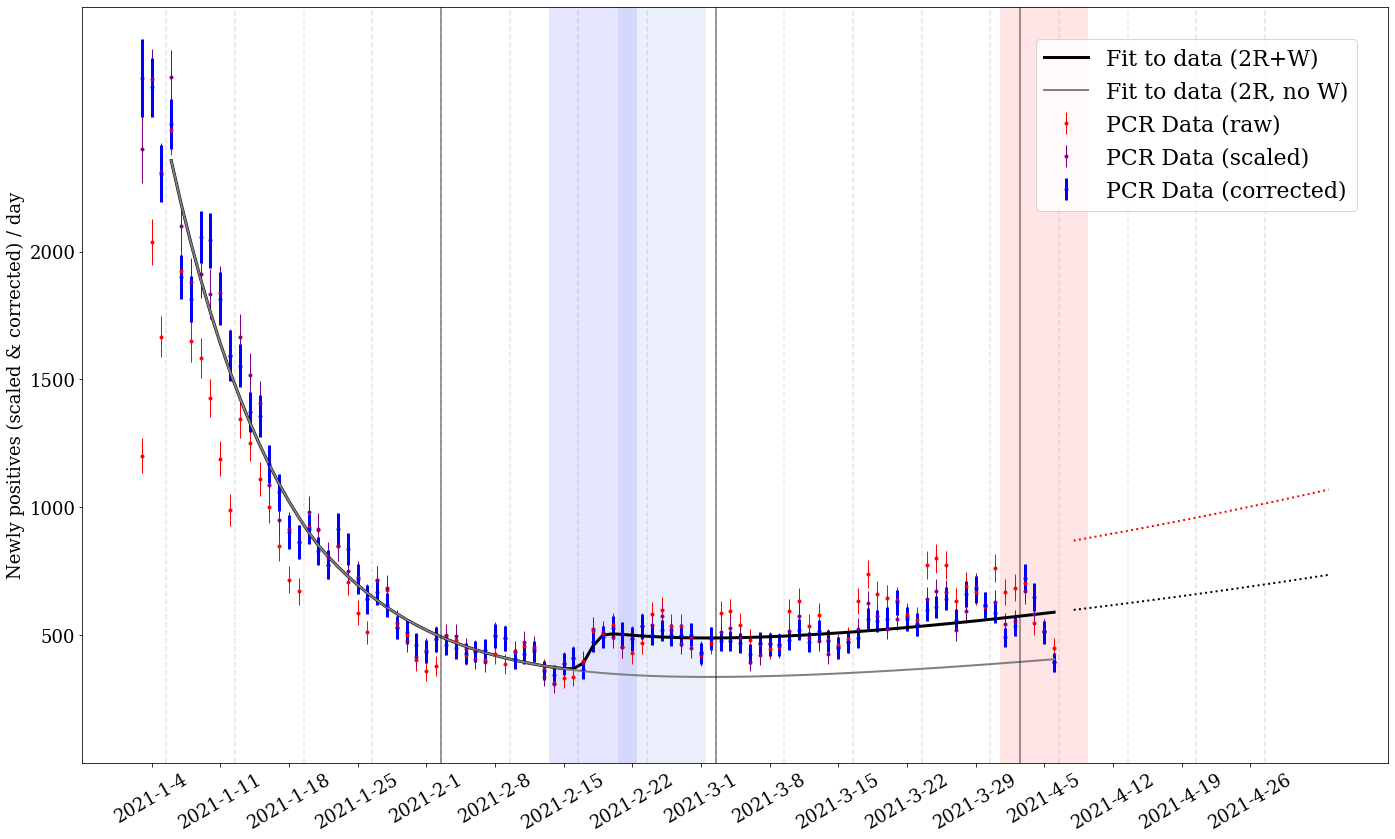

In [11]:
# Put dates on the x-axis:
now = dt.datetime.now()         # Changed to the last date of data?
then = now + dt.timedelta(days=-(Plot_EndDay-Plot_StartDay))
dato_start = "2021-01-01"

fig, ax = plt.subplots(figsize=(20, 12))
ax.set(xlabel="", ylabel="Newly positives (scaled & corrected) / day", title="")
ax.errorbar(day1jan, P_all[Plot_StartDay:Plot_EndDay], yerr=eP_all[Plot_StartDay:Plot_EndDay], fmt='.', linewidth=1, label='PCR Data (raw)', color='red')
ax.errorbar(day1jan, SP_all[Plot_StartDay:Plot_EndDay], yerr=eSP_all[Plot_StartDay:Plot_EndDay], fmt='.', linewidth=1, label='PCR Data (scaled)', color='purple')
ax.errorbar(day1jan, SCP_all[Plot_StartDay:Plot_EndDay], yerr=eSCP_all[Plot_StartDay:Plot_EndDay], fmt='.', linewidth=3, label='PCR Data (corrected)', color='blue')

# Plot the fit model on top of data:
#ax.plot(day1jan_fitJan, func_Expo(day1jan_fitJan, N0_fit, Rt_fit, t0_fit, tG_fit), 'green', linewidth=1.0, label='Exp. fit (no B117)')
#ax.plot(day1jan_fitJan, func_DoubleExpo(day1jan_fitJan, N0_fit2, Rt_fit2, t0_fit2, tG), 'blue',  linewidth=1.0, label='Fit to data')

# ax.plot(day1jan_fit,    func_DoubleExpoStep_vec(day1jan_fit,  N0_fit3, Rb_fit3, Ra_fit3, t0_fit3, tG), 'red', linewidth=2.0, label='Fit to data (2R)')
# ax.plot(day_extrapol,   func_DoubleExpoStep_vec(day_extrapol, N0_fit3, Rb_fit3, Ra_fit3, t0_fit3, tG), 'red', linewidth=1.0, linestyle="dotted")
#ax.plot(day1jan_fit,    func_DoubleExpoStep2_vec(day1jan_fit, N0_fit4, Rb_fit4, Ra_fit4, Rc_fit4, t0_fit4, t1_fit4, tG), 'green', linewidth=1.0, label='Fit to data (3R)')
ax.plot(day1jan_fit,    func_DoubleExpoStepW_vec(day1jan_fit,  N0_fit3w, Rb_fit3w, Ra_fit3w, t0_fit3w, fW_fit3w, tW_fit3w, sW_fit3w, tG), 'black', linewidth=3.0, label='Fit to data (2R+W)')
ax.plot(day_extrapol,   func_DoubleExpoStepW_vec(day_extrapol, N0_fit3w, Rb_fit3w, Ra_fit3w, t0_fit3w, fW_fit3w, tW_fit3w, sW_fit3w, tG), 'black', linewidth=2.0, linestyle="dotted")

# Plot with Easter vacation in prediction (assuming same size)
dayEaster = 31+28+28
ax.plot(day_extrapol,   func_DoubleExpoStepWE_vec(day_extrapol,N0_fit3w, Rb_fit3w, Ra_fit3w, t0_fit3w, fW_fit3w, tW_fit3w, sW_fit3w, fW_fit3w, dayEaster+tG, tG), 'red', linewidth=2.0, linestyle="dotted")

# Without Winter vacation:
ax.plot(day1jan_fit,    func_DoubleExpoStepW_vec(day1jan_fit,  N0_fit3w, Rb_fit3w, Ra_fit3w, t0_fit3w, 0.0, tW_fit3w, sW_fit3w, tG), 'grey', linewidth=2.0, label='Fit to data (2R, no W)')
# ax.plot(day_extrapol,   func_DoubleExpoStepW_vec(day_extrapol, N0_fit3w, Rb_fit3w, Ra_fit3w, t0_fit3w, 0.0, tW_fit3w, sW_fit3w, tG), 'grey', linewidth=1.0, linestyle="dotted")

# Dividing into DK and UK/B117 versions:
# ax.plot(day1jan_fit,    func_StepRDK_vec(day1jan_fit,   N0_fit3, Rb_fit3, Ra_fit3, t0_fit3, tG), 'green', linewidth=1.0, label='Only DK version')
# ax.plot(day1jan_fit,    func_StepRB117_vec(day1jan_fit, N0_fit3, Rb_fit3, Ra_fit3, t0_fit3, tG), 'blue', linewidth=1.0, label='Only B117 version')

# Plot an "envelope" of possible predictions:
#ax.plot(day_extrapol, func_DoubleExpoStep_vec(day_extrapol, N0_fit3, Rb_fit3, Ra_fit3+2*sigma_Ra_fit3, t0_fit3, tG), 'red', linewidth=1.0, linestyle="dotted")
#ax.plot(day_extrapol, func_DoubleExpoStep_vec(day_extrapol, N0_fit3, Rb_fit3, Ra_fit3-2*sigma_Ra_fit3, t0_fit3, tG), 'red', linewidth=1.0, linestyle="dotted")
#ax.fill_between(day_extrapol, func_DoubleExpoStep_vec(day_extrapol, N0_fit3, Rb_fit3, Ra_fit3+2*sigma_Ra_fit3, t0_fit3, tG), func_DoubleExpoStep_vec(day_extrapol, N0_fit3, Rb_fit3, Ra_fit3-2*sigma_Ra_fit3, t0_fit3, tG), color='red', alpha=0.3, label='Extrapolation')

# Put nice labels on the original axis:
plt.xticks(ticks=np.arange(1,len(P_all[dato_start:]),7), labels=np.array(P_all[dato_start::7].index), rotation=30)
for x in np.arange(2.5, max(day_extrapol), 7): 
    plt.axvline( x, ls='--', color='grey', alpha=0.2)

times = []; N_weeks = int(max(day_extrapol)/7)
for i in range(N_weeks):
    times.append(then + dt.timedelta(days=7*i))
    
plt.xticks(ticks=[7*i+1 for i in range(N_weeks)], 
           labels=[str(time.year)+'-'+str(time.month)+'-'+str(time.day) for time in times])

# Plot monthly lines on first date:
d_now = dt.date(year=int(date_start[:4]), month = int(date_start[5:7]), day = int(date_start[8:] ))
for i in range(len(data_posi.loc[date_start:date_end].sum(axis=1))):
    d_now = d_now + dt.timedelta(days=1)
    if d_now.day == 1:
        plt.axvline( i+0.5, ls='-', color='k', alpha=0.5)

# Show the Winter vacation
# ax.axvspan(41.5, 50.5, facecolor='r', alpha=0.1, label="Winter vacation (W7)")
# ax.axvspan(48.5, 57.5, facecolor='b', alpha=0.1, label="Winter vacation (W8)")
ax.axvspan(41.5, 50.5, facecolor='b', alpha=0.1)
ax.axvspan(48.5, 57.5, facecolor='royalblue', alpha=0.1)
ax.axvspan(dayEaster+0.5, dayEaster+9.5, facecolor='r', alpha=0.1)

# Plot the fraction of B117 on secondary y-axis (to the right):
#ax2 = ax.twinx()
#ax2.plot(day_all, func_logistic(day_all-33, *[frac_t0_fit, tau_fit]), color="red", marker="", alpha=0.2)
#ax2.set_ylabel("Fraction B117", color="red", fontsize=22)
#ax2.tick_params(axis='y', colors='red')

do_log = False
if (do_log) :
    plt.yscale("log")
    ax.set_yticks([250,500,1000,2000])
    ax.set_ylim([180.0,None]) 
    ax.legend(loc=(0.03, 0.03), fontsize=22)
else :
    ax.set_yticks([500,1000,1500,2000])
    ax.set_ylim([0.0,None]) 
    ax.legend(loc=(0.73, 0.73), fontsize=22)

ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

plt.tight_layout()
if (save_plots) :
    if (do_log) :
        plt.savefig("fig_FitOfPCRdata_WithDKandUKversions_Log.pdf")
    else :
        plt.savefig("fig_FitOfPCRdata_WithDKandUKversions_Lin.pdf")

***

# Combination into forecast:

The above two fits makes it possible to forecast the development of the two vira:
- DK version: PCR-fit * (1-frac(t)), up to t0
              PCR-fit * (1-frac(t0), after t0
- UK version: PCR-fit * frac(t), up to t0
              PCR-fit(R*1.45) * frac(t), after t0

In [12]:
"""
fig2, ax2 = plt.subplots(figsize=(15, 8))
ax2.set(xlabel="Days in 2021 (1st of January is day 1)", ylabel="Newly infected / day", title="")

Ndays_offset = 5           # The B.1.1.7 data goes to the 12th, while the PCR goes to the 17th
day1jan_frac = np.arange(-len(day1jan_fit) + Ndays_offset, 0)
dayNjan_future = np.arange(0,Nfuture)

print(day1jan_frac)
print(day1jan)
print(dayNjan_future)

ax2.plot(day1jan_fit,    func_Expo(day1jan_fit,    N0_fit, Rt_fit,      t0_fit, tG_fit) * (1.0 - func_logistic(day1jan_frac, *[frac_t0_fit, tau_fit])),   label='DK - From fit', color="blue")
ax2.plot(day1jan_fit,    func_Expo(day1jan_fit,    N0_fit, Rt_fit*1.45, t0_fit, tG_fit) * func_logistic(day1jan_frac, *[frac_t0_fit, tau_fit]),           label='UK - From fit', color="red")
#ax2.plot(dayNjan_future, func_Expo(dayNjan_future, N0_fit, Rt_fit,      t0_fit, tG_fit) * (1.0 - func_logistic(dayNjan_future, *[frac_t0_fit, tau_fit])), label='DK - Extrapolation', color="blue", linestyle=":")
#ax2.plot(dayNjan_future, func_Expo(dayNjan_future, N0_fit, Rt_fit*1.45, t0_fit, tG_fit) * func_logistic(dayNjan_future, *[frac_t0_fit, tau_fit]),         label='UK - Extrapolation', color="red", linestyle=":")
#ax2.plot(dayNjan_future, fit_exp(np.arange(0,Nfuture), *[frac_t0_fit, tau_fit]), label='DK - Extrapolation', color="blue", linestyle=":")


# Plot an "envelope" of possible predictions:
plt.plot(np.arange(0,Nfuture), fit_exp(np.arange(0,Nfuture), *[frac_t0_fit+Nsig*dfrac_t0_fit, tau_fit-Nsig*dtau_fit]), label='LLH', color="blue", linestyle=":")
plt.plot(np.arange(0,Nfuture), fit_exp(np.arange(0,Nfuture), *[frac_t0_fit-Nsig*dfrac_t0_fit, tau_fit+Nsig*dtau_fit]), label='LLH', color="blue", linestyle=":")
plt.fill_between(np.arange(0,Nfuture), fit_exp(np.arange(0,Nfuture), *[frac_t0_fit+Nsig*dfrac_t0_fit, tau_fit-Nsig*dtau_fit]), fit_exp(np.arange(0,Nfuture), *[frac_t0_fit-Nsig*dfrac_t0_fit, tau_fit+Nsig*dtau_fit]), color='blue', alpha=0.3)

# Show estimate of "British take-over":
plt.axhline(y=0.5,  xmin=-Ndays, xmax=Nfuture, color='black', linewidth=2.0, linestyle="dotted")
plt.axvline(x=34.0, ymin=0.0,    ymax=0.5,     color='black', linewidth=2.0, linestyle="dotted")

plt.xlim(-Ndays,Nfuture)
plt.ylabel('Fraction of B.1.1.7', fontsize=22)
plt.xlabel('Dates relative to '+str(dates[-1].day)+'-'+str(dates[-1].month)+'-'+str(dates[-1].year), fontsize=22 )




plt.legend()
plt.tight_layout()
if (save_plots) :
    plt.savefig("fig_Extrapolation.pdf")
"""

'\nfig2, ax2 = plt.subplots(figsize=(15, 8))\nax2.set(xlabel="Days in 2021 (1st of January is day 1)", ylabel="Newly infected / day", title="")\n\nNdays_offset = 5           # The B.1.1.7 data goes to the 12th, while the PCR goes to the 17th\nday1jan_frac = np.arange(-len(day1jan_fit) + Ndays_offset, 0)\ndayNjan_future = np.arange(0,Nfuture)\n\nprint(day1jan_frac)\nprint(day1jan)\nprint(dayNjan_future)\n\nax2.plot(day1jan_fit,    func_Expo(day1jan_fit,    N0_fit, Rt_fit,      t0_fit, tG_fit) * (1.0 - func_logistic(day1jan_frac, *[frac_t0_fit, tau_fit])),   label=\'DK - From fit\', color="blue")\nax2.plot(day1jan_fit,    func_Expo(day1jan_fit,    N0_fit, Rt_fit*1.45, t0_fit, tG_fit) * func_logistic(day1jan_frac, *[frac_t0_fit, tau_fit]),           label=\'UK - From fit\', color="red")\n#ax2.plot(dayNjan_future, func_Expo(dayNjan_future, N0_fit, Rt_fit,      t0_fit, tG_fit) * (1.0 - func_logistic(dayNjan_future, *[frac_t0_fit, tau_fit])), label=\'DK - Extrapolation\', color="blue", lines

# Finding R as a function of time for arbitrary, centered intervals
Here $n$ must be an odd integer (could be made to work with any integer)

In [13]:
#Interval of days to be fitted for each R
n = 11
k = int((n-1)/2) #Used to get interval



# Print how much data is included:
date_start_c = "2020-09-01"            # This is thus day 0
date_end_c = "2021-03-26"          # Value in latest report files
print("  Data used: ", date_start, "-", date_end)    

# Number of Positives (P) and Tests (T) for all of Denmark ("all")
P_all = data_posi.loc[date_start_c:date_end_c].sum(axis=1)
eP_all = np.sqrt(P_all)
T_all = data_test.loc[date_start_c:date_end_c].sum(axis=1)
eT_all = np.sqrt(T_all)

# These are also the days where corrections are applied:
Plot_StartDay = 0         # Whenever we start
Plot_EndDay   = len(P_all)

# Calculate the Scaled Positives (SP):
nAveDailyTests_all = T_all.mean()
print("Average number of PCR tests: ", nAveDailyTests_all)
fPos_all = P_all / T_all
efPos_all = np.sqrt(fPos_all*(1.0-fPos_all)/T_all + SystError**2)
eP_all  = np.sqrt(T_all*fPos_all*(1-fPos_all)) * (1.0 + SystErrorScale)
SP_all  = P_all  * (T_all / nAveDailyTests_all)**Power
eSP_all = eP_all * (T_all / nAveDailyTests_all)**Power

# Calculate the Scaled CORRECTED Positives (SCP), i.e. apply correction for weekdays:
SCP_all = np.zeros_like(SP_all)
eSCP_all = np.zeros_like(eSP_all)
for i,x,dx in zip(np.arange(Plot_StartDay,Plot_StartDay+len(SP_all[Plot_StartDay:Plot_EndDay])),
                  SP_all[Plot_StartDay:Plot_EndDay], eSP_all[Plot_StartDay:Plot_EndDay]) :
    factor = 1.0               # Just for testing, if the "strength" of the effect is reasonable
    SCP_all[i] = x*(1 - factor * frac_fra_lørdag[i%7])
    eSCP_all[i] = dx*(1 - factor * frac_fra_lørdag[i%7])


  Data used:  2021-01-01 - 2021-04-04
Average number of PCR tests:  87756.12077294686


In [14]:
data_Rt = pd.read_csv("../Data-Epidemiologiske-Rapport-24032021-6m2k/Rt_cases_2021_04_06.csv", sep=';', thousands='.',decimal=',', index_col=0)

Rt_ref = data_Rt.loc[date_start_c:date_end_c]


R_t_central = Rt_ref["estimate"][k:Plot_EndDay-k]
R_t_referr = (Rt_ref["uncertainty_upper"]-Rt_ref["uncertainty_lower"])[k:Plot_EndDay-k] / 4

SampleDate
2020-09-06    1.2
2020-09-07    1.2
2020-09-08    1.2
2020-09-09    1.2
2020-09-10    1.1
             ... 
2021-03-17    1.0
2021-03-18    1.0
2021-03-19    1.0
2021-03-20    1.0
2021-03-21    1.0
Name: estimate, Length: 197, dtype: float64


Day 20 is not valid!
Prob(Chi2= 30.7, Ndof= 9) = 0.000
Rt fit = 1.002 +- 0.038
S0 fit = 651.214 +- 17.483 with start value 734.120


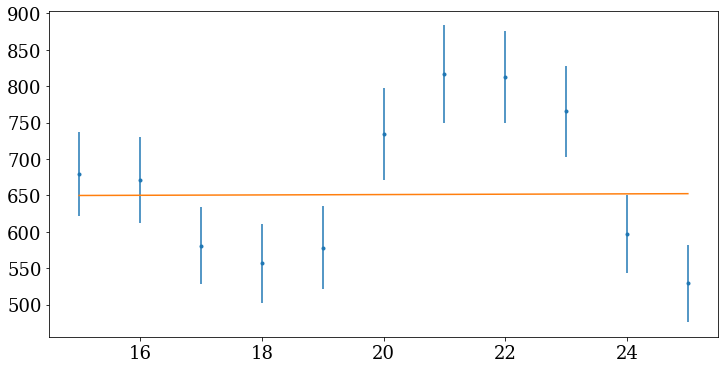

Day 21 is not valid!
Prob(Chi2= 35.1, Ndof= 9) = 0.000
Rt fit = 0.969 +- 0.036
S0 fit = 634.865 +- 17.384 with start value 816.332


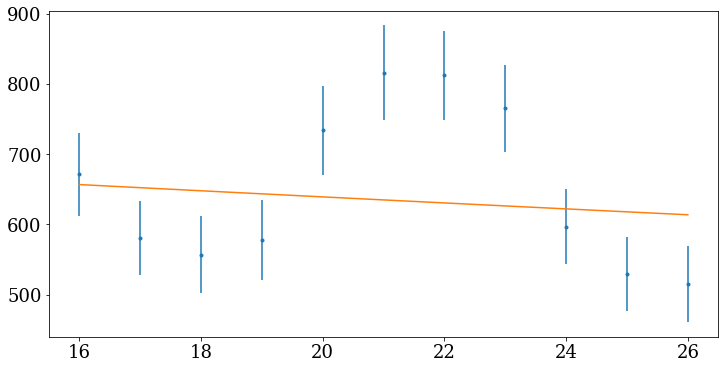

Day 22 is not valid!
Prob(Chi2= 35.6, Ndof= 9) = 0.000
Rt fit = 0.988 +- 0.037
S0 fit = 633.936 +- 17.418 with start value 812.285


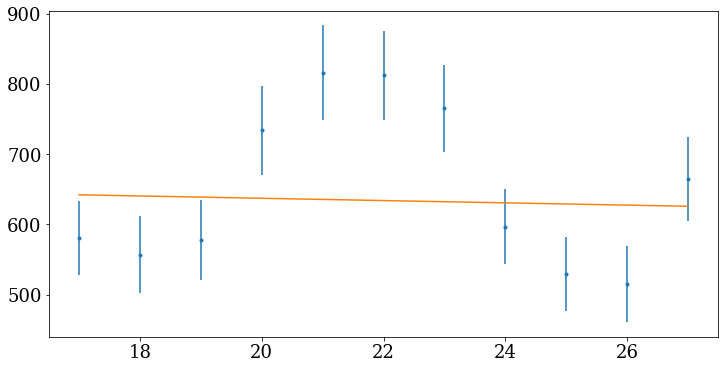

Day 23 is not valid!
Prob(Chi2= 34.1, Ndof= 9) = 0.000
Rt fit = 0.970 +- 0.038
S0 fit = 642.169 +- 17.683 with start value 765.348


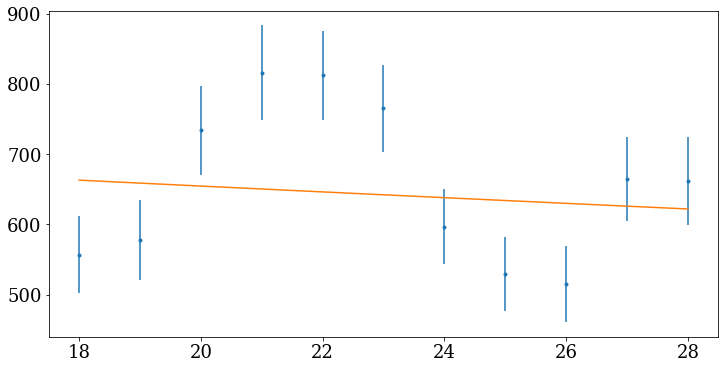

Day 24 is not valid!
Prob(Chi2= 28.0, Ndof= 9) = 0.001
Rt fit = 0.911 +- 0.037
S0 fit = 646.235 +- 17.761 with start value 596.585


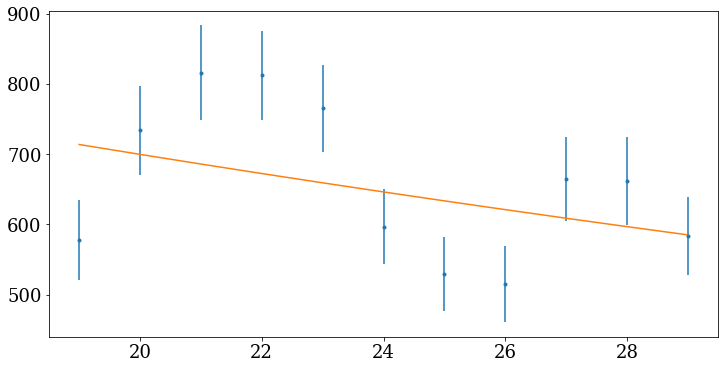

Day 48 is not valid!
Prob(Chi2= 27.9, Ndof= 9) = 0.001
Rt fit = 1.285 +- 0.043
S0 fit = 900.360 +- 21.959 with start value 1001.540


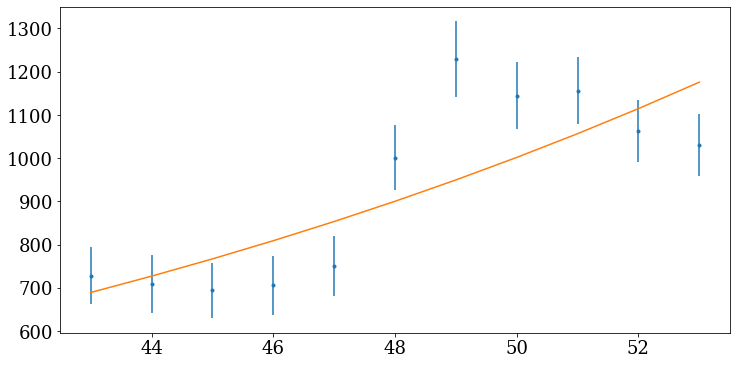

Day 49 is not valid!
Prob(Chi2= 28.4, Ndof= 9) = 0.001
Rt fit = 1.275 +- 0.042
S0 fit = 939.170 +- 22.199 with start value 1228.990


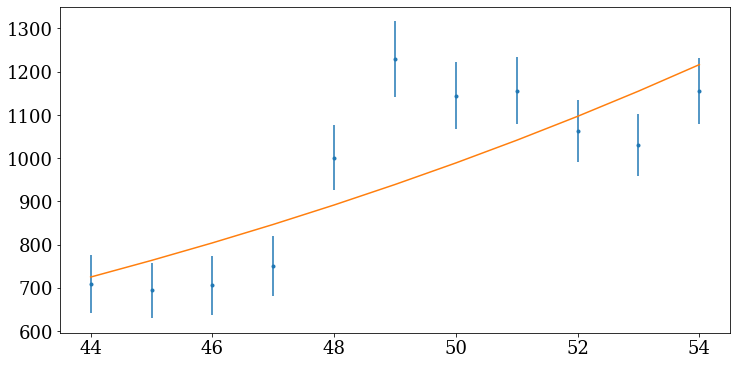

Day 50 is not valid!
Prob(Chi2= 28.4, Ndof= 9) = 0.001
Rt fit = 1.262 +- 0.040
S0 fit = 988.710 +- 22.519 with start value 1144.939


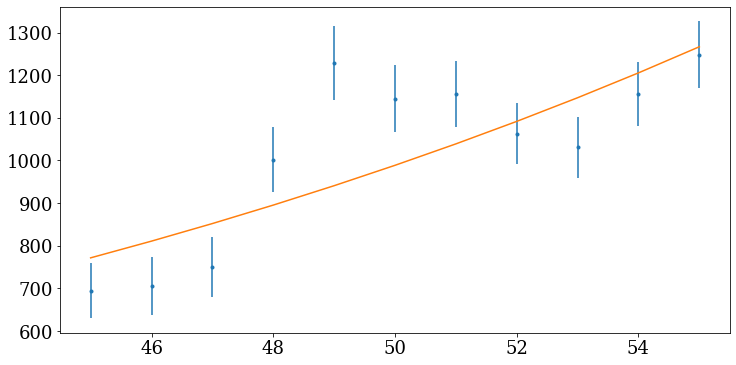

Day 51 is not valid!
Prob(Chi2= 30.5, Ndof= 9) = 0.000
Rt fit = 1.275 +- 0.041
S0 fit = 1060.824 +- 23.202 with start value 1156.307


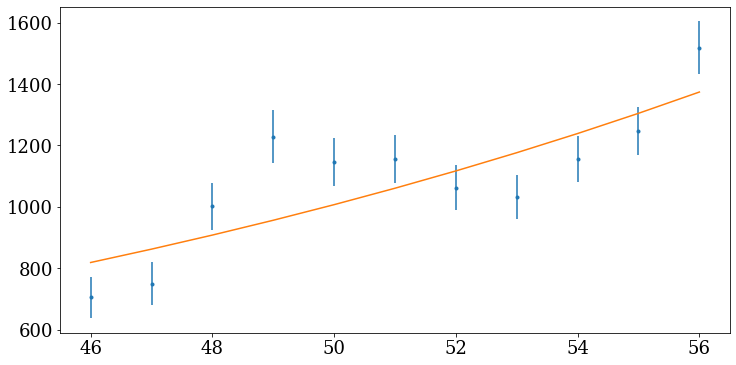

Day 57 is not valid!
Prob(Chi2= 33.2, Ndof= 9) = 0.000
Rt fit = 1.089 +- 0.030
S0 fit = 1217.689 +- 22.887 with start value 1333.021


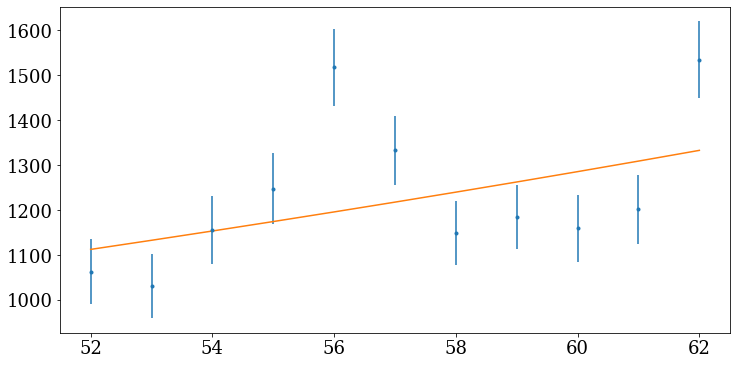

Day 58 is not valid!
Prob(Chi2= 36.0, Ndof= 9) = 0.000
Rt fit = 1.106 +- 0.031
S0 fit = 1257.923 +- 23.257 with start value 1148.769


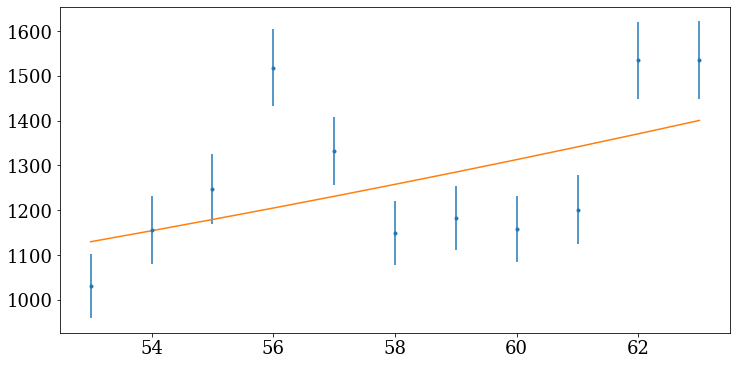

Day 59 is not valid!
Prob(Chi2= 33.2, Ndof= 9) = 0.000
Rt fit = 1.068 +- 0.030
S0 fit = 1290.737 +- 23.401 with start value 1183.750


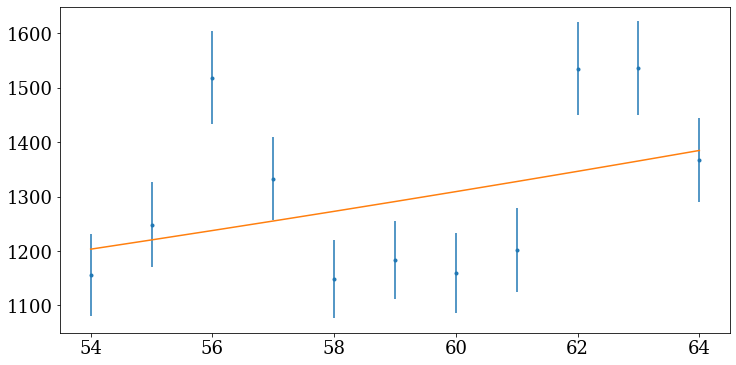

Day 60 is not valid!
Prob(Chi2= 39.9, Ndof= 9) = 0.000
Rt fit = 1.004 +- 0.027
S0 fit = 1287.382 +- 23.221 with start value 1159.051


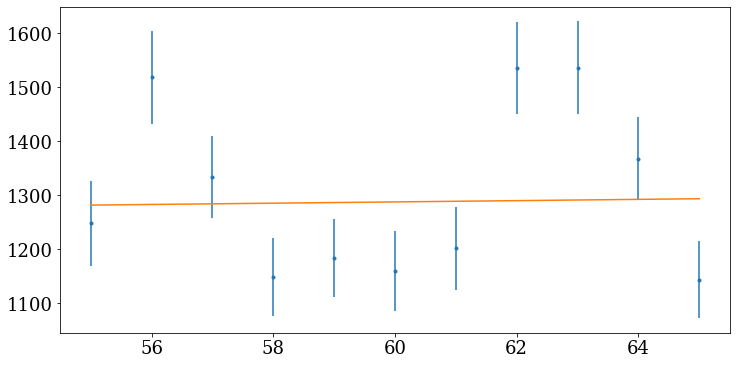

Day 61 is not valid!
Prob(Chi2= 50.5, Ndof= 9) = 0.000
Rt fit = 0.941 +- 0.025
S0 fit = 1258.911 +- 22.792 with start value 1201.366


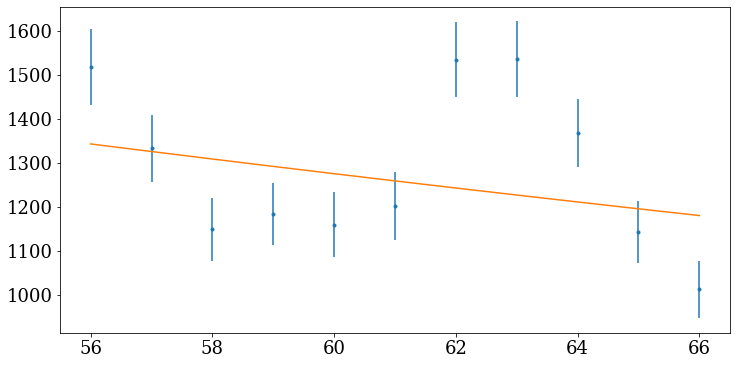

Day 62 is not valid!
Prob(Chi2= 55.5, Ndof= 9) = 0.000
Rt fit = 0.924 +- 0.023
S0 fit = 1204.004 +- 22.195 with start value 1534.680


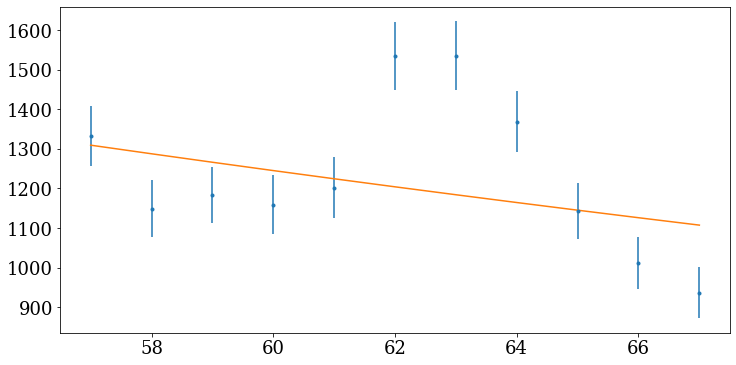

Day 63 is not valid!
Prob(Chi2= 63.2, Ndof= 9) = 0.000
Rt fit = 0.894 +- 0.023
S0 fit = 1158.731 +- 21.856 with start value 1535.458


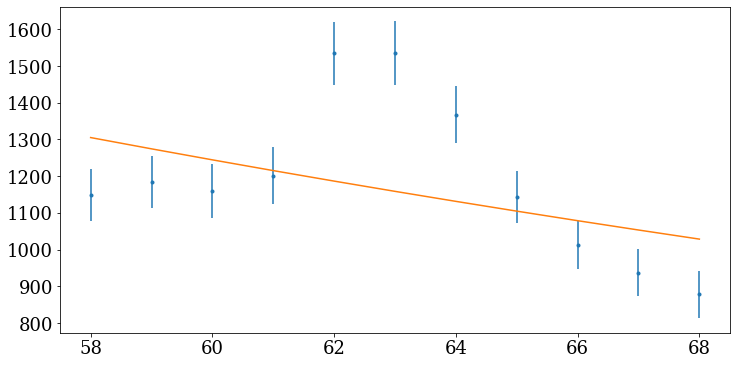

Day 64 is not valid!
Prob(Chi2= 61.5, Ndof= 9) = 0.000
Rt fit = 0.885 +- 0.023
S0 fit = 1161.162 +- 21.872 with start value 1367.742


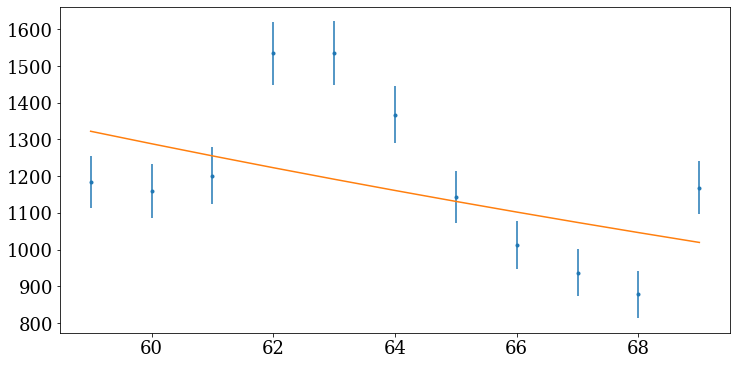

Day 65 is not valid!
Prob(Chi2= 65.6, Ndof= 9) = 0.000
Rt fit = 0.886 +- 0.025
S0 fit = 1164.432 +- 21.973 with start value 1143.376


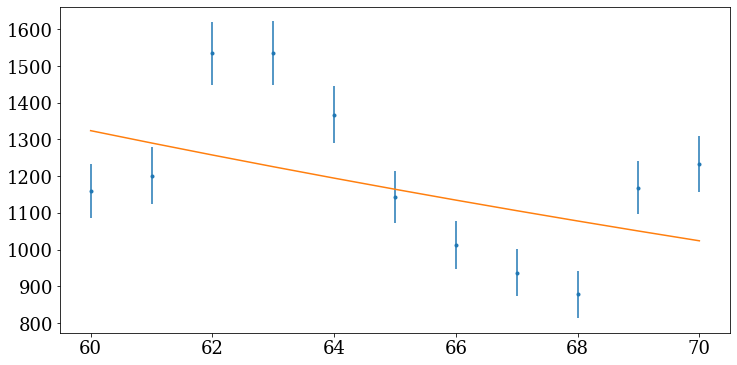

Day 66 is not valid!
Prob(Chi2= 63.9, Ndof= 9) = 0.000
Rt fit = 0.875 +- 0.026
S0 fit = 1165.523 +- 21.885 with start value 1012.125


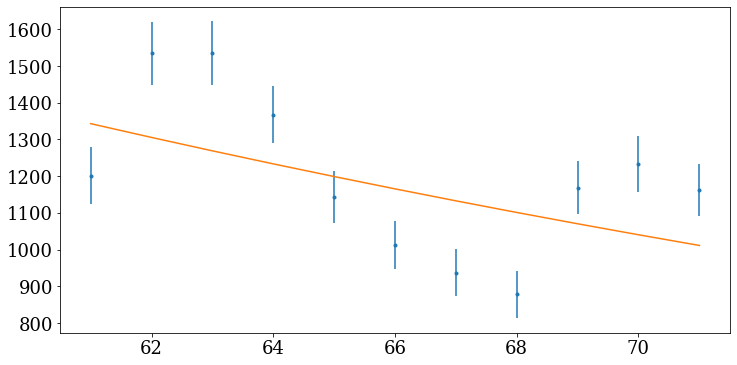

Day 67 is not valid!
Prob(Chi2= 64.5, Ndof= 9) = 0.000
Rt fit = 0.873 +- 0.028
S0 fit = 1159.591 +- 21.712 with start value 936.897


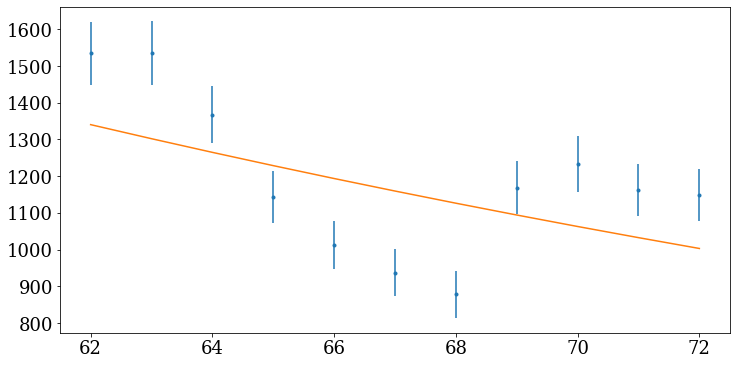

Day 68 is not valid!
Prob(Chi2= 60.5, Ndof= 9) = 0.000
Rt fit = 0.955 +- 0.030
S0 fit = 1135.601 +- 21.297 with start value 878.142


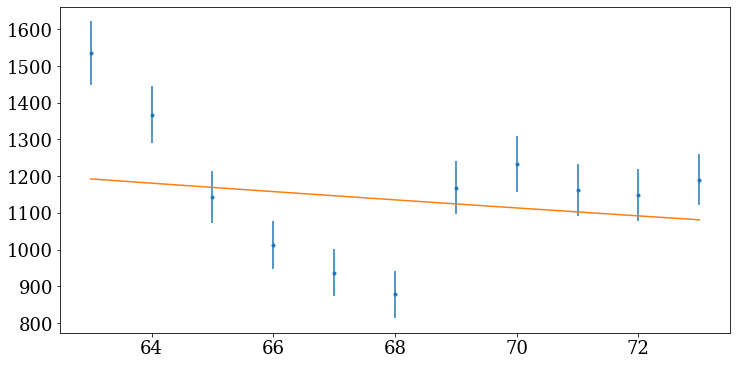

Day 69 is not valid!
Prob(Chi2= 39.2, Ndof= 9) = 0.000
Rt fit = 1.037 +- 0.031
S0 fit = 1115.234 +- 21.040 with start value 1168.503


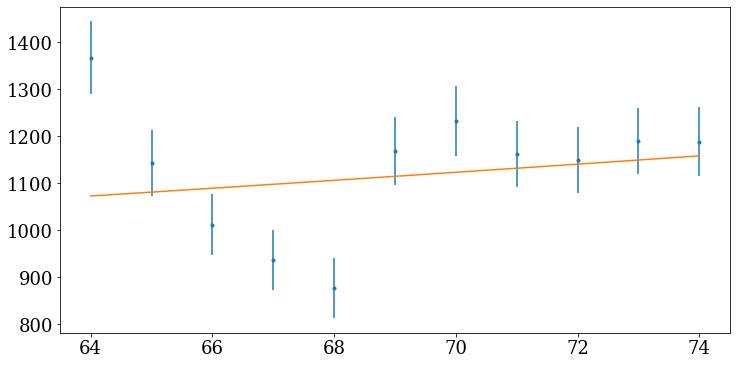

Day 77 is not valid!
Prob(Chi2= 28.3, Ndof= 9) = 0.001
Rt fit = 1.009 +- 0.025
S0 fit = 1258.009 +- 22.339 with start value 1537.203


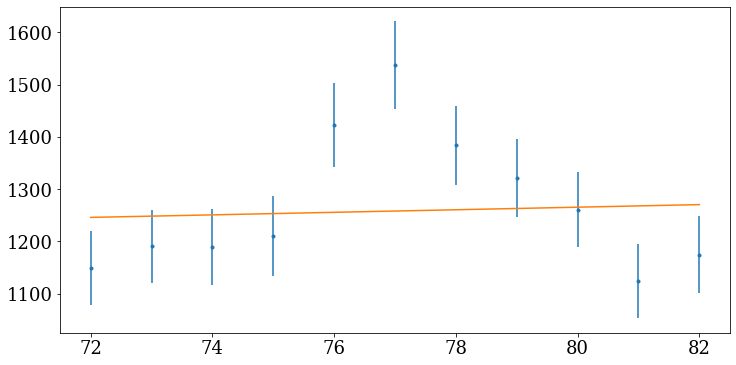

Day 79 is not valid!
Prob(Chi2= 32.4, Ndof= 9) = 0.000
Rt fit = 1.016 +- 0.027
S0 fit = 1306.152 +- 22.928 with start value 1321.441


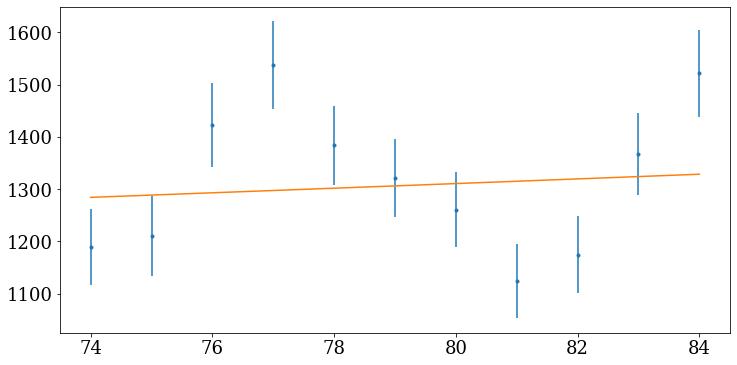

Day 80 is not valid!
Prob(Chi2= 30.1, Ndof= 9) = 0.000
Rt fit = 1.000 +- 0.027
S0 fit = 1323.115 +- 22.984 with start value 1260.548


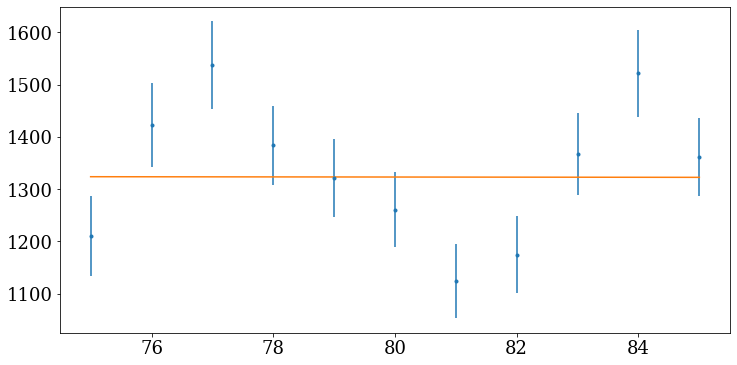

Day 86 is not valid!
Prob(Chi2= 35.2, Ndof= 9) = 0.000
Rt fit = 1.197 +- 0.032
S0 fit = 1395.428 +- 23.710 with start value 1317.329


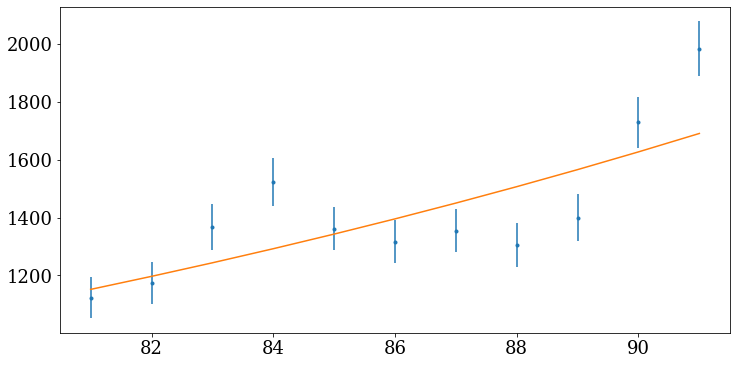

Day 87 is not valid!
Prob(Chi2= 37.0, Ndof= 9) = 0.000
Rt fit = 1.217 +- 0.032
S0 fit = 1463.708 +- 24.218 with start value 1354.152


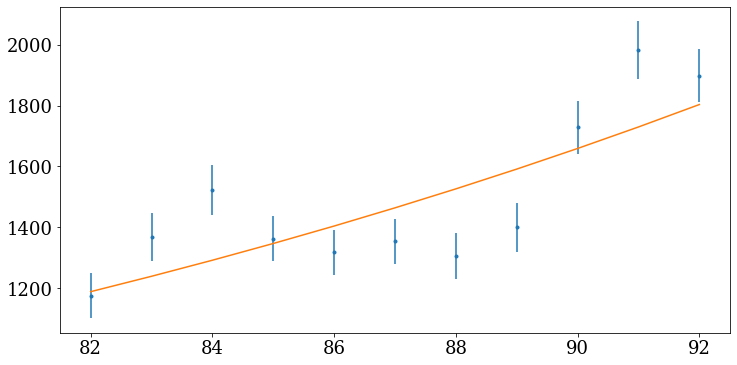

Day 88 is not valid!
Prob(Chi2= 37.0, Ndof= 9) = 0.000
Rt fit = 1.219 +- 0.030
S0 fit = 1529.794 +- 24.604 with start value 1304.643


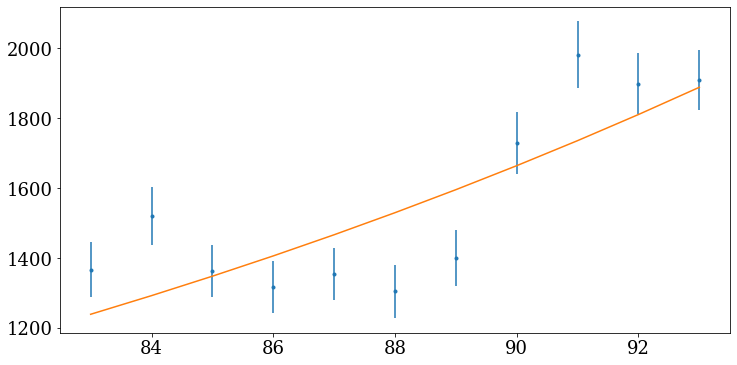

Day 89 is not valid!
Prob(Chi2= 33.7, Ndof= 9) = 0.000
Rt fit = 1.241 +- 0.029
S0 fit = 1581.794 +- 24.844 with start value 1400.042


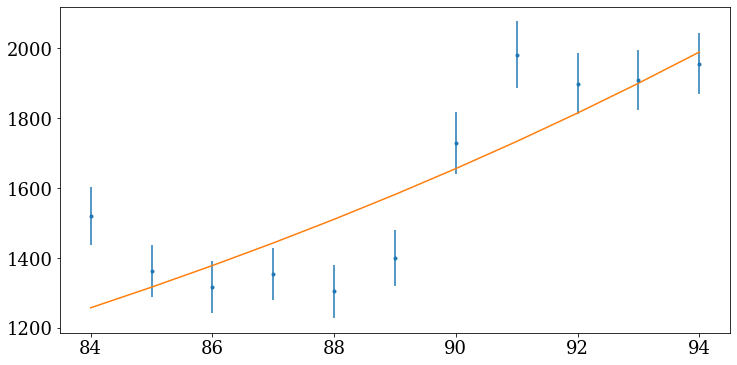

Day 90 is not valid!
Prob(Chi2= 28.5, Ndof= 9) = 0.001
Rt fit = 1.243 +- 0.027
S0 fit = 1613.657 +- 24.944 with start value 1729.245


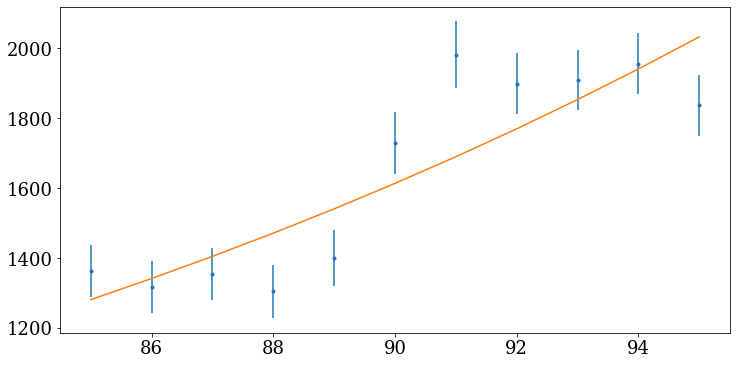

Day 92 is not valid!
Prob(Chi2= 45.1, Ndof= 9) = 0.000
Rt fit = 1.328 +- 0.029
S0 fit = 1799.353 +- 26.500 with start value 1899.160


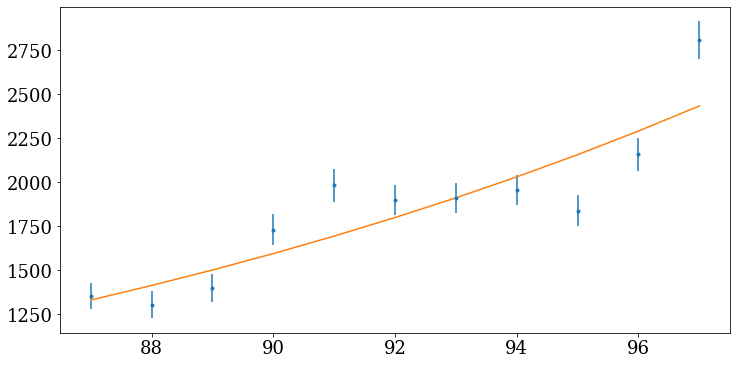

Day 93 is not valid!
Prob(Chi2= 59.9, Ndof= 9) = 0.000
Rt fit = 1.403 +- 0.031
S0 fit = 1936.564 +- 27.672 with start value 1909.396


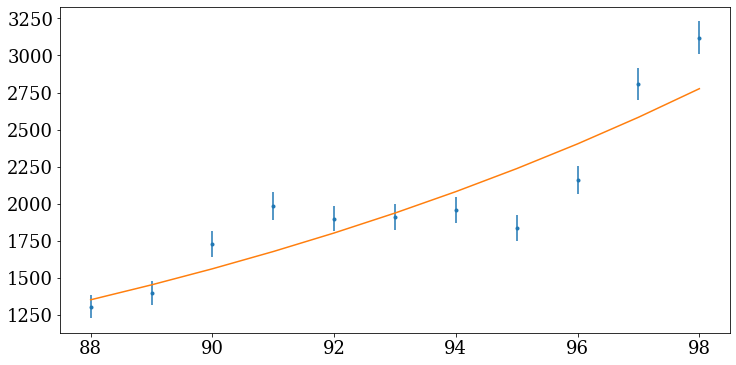

Day 94 is not valid!
Prob(Chi2= 60.3, Ndof= 9) = 0.000
Rt fit = 1.370 +- 0.028
S0 fit = 2078.522 +- 28.330 with start value 1956.523


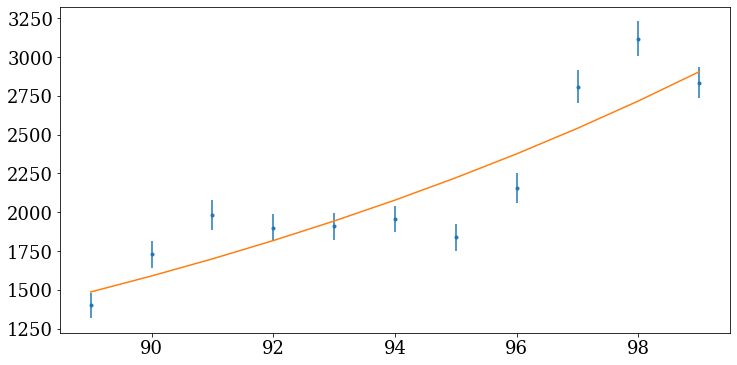

Day 95 is not valid!
Prob(Chi2= 59.8, Ndof= 9) = 0.000
Rt fit = 1.333 +- 0.026
S0 fit = 2223.568 +- 28.844 with start value 1837.579


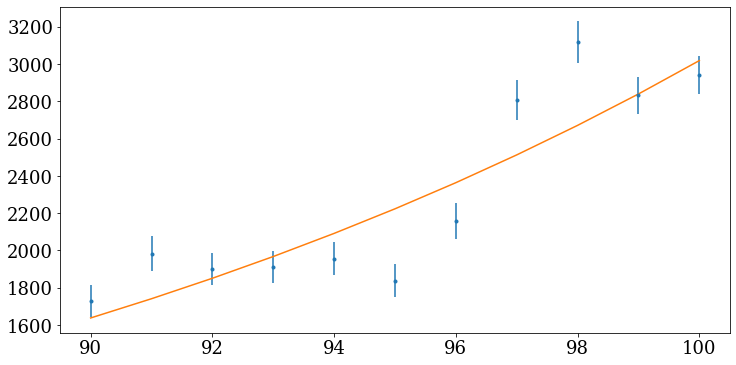

Day 96 is not valid!
Prob(Chi2= 67.5, Ndof= 9) = 0.000
Rt fit = 1.300 +- 0.024
S0 fit = 2327.797 +- 29.049 with start value 2158.229


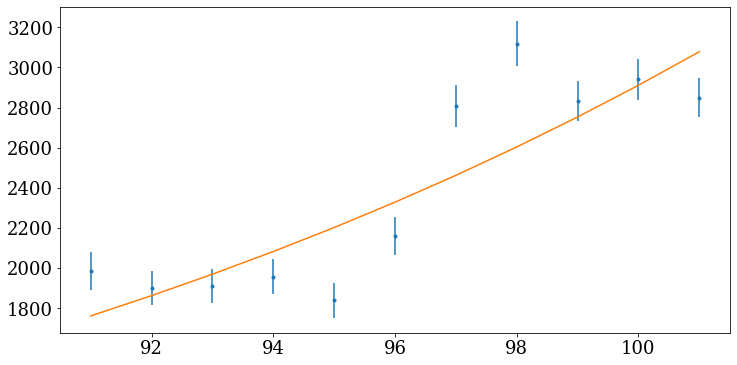

Day 97 is not valid!
Prob(Chi2= 73.9, Ndof= 9) = 0.000
Rt fit = 1.280 +- 0.022
S0 fit = 2410.007 +- 29.105 with start value 2808.362


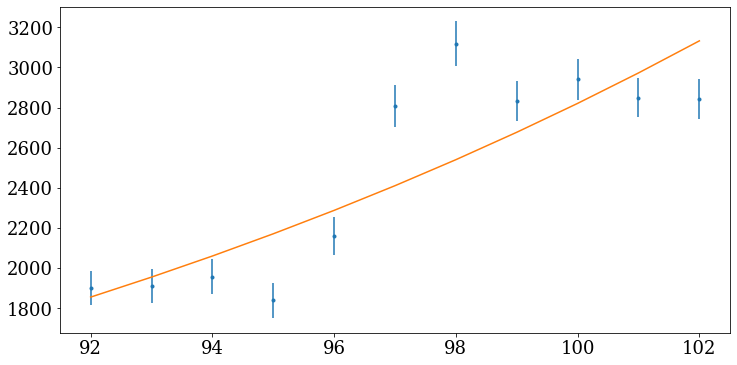

Day 98 is not valid!
Prob(Chi2= 76.5, Ndof= 9) = 0.000
Rt fit = 1.266 +- 0.021
S0 fit = 2519.939 +- 29.633 with start value 3119.186


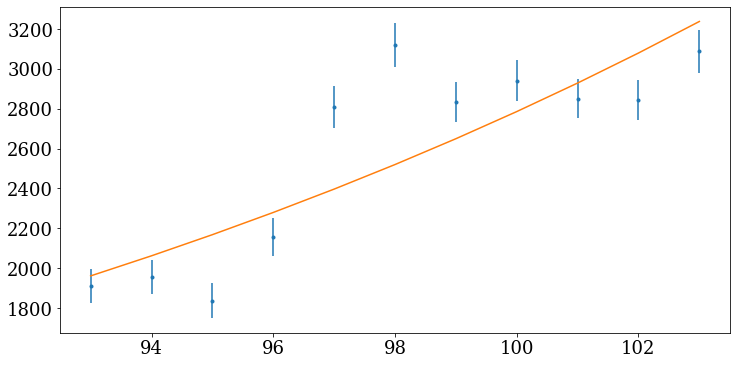

Day 99 is not valid!
Prob(Chi2= 79.0, Ndof= 9) = 0.000
Rt fit = 1.278 +- 0.021
S0 fit = 2670.477 +- 30.406 with start value 2834.185


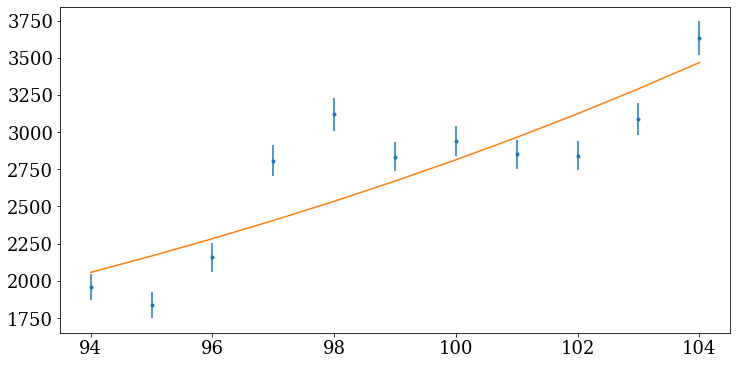

Day 100 is not valid!
Prob(Chi2= 80.3, Ndof= 9) = 0.000
Rt fit = 1.284 +- 0.021
S0 fit = 2840.760 +- 31.305 with start value 2941.021


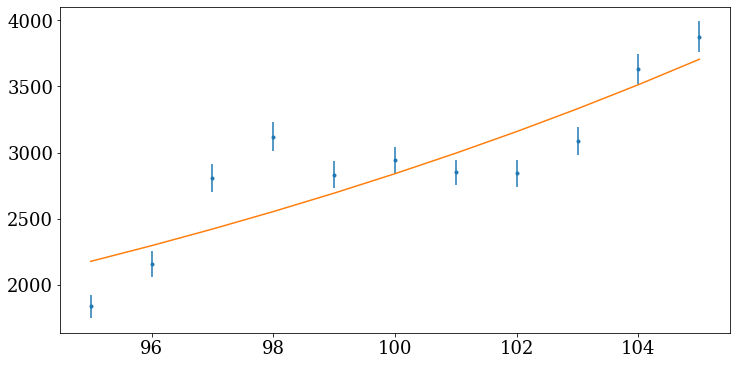

Day 101 is not valid!
Prob(Chi2= 62.2, Ndof= 9) = 0.000
Rt fit = 1.200 +- 0.019
S0 fit = 3012.928 +- 31.706 with start value 2849.945


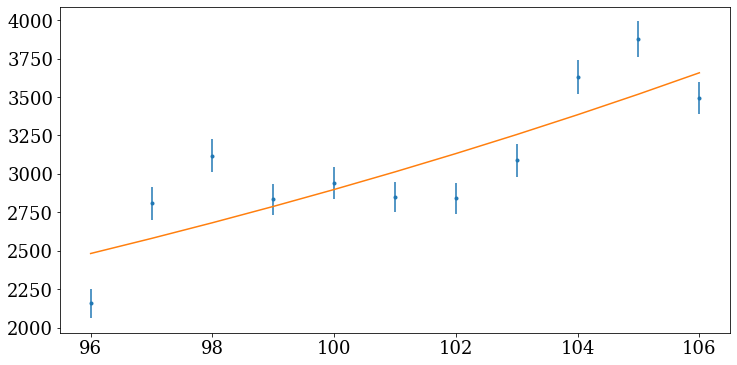

Day 102 is not valid!
Prob(Chi2= 83.4, Ndof= 9) = 0.000
Rt fit = 1.086 +- 0.016
S0 fit = 3091.107 +- 31.522 with start value 2842.313


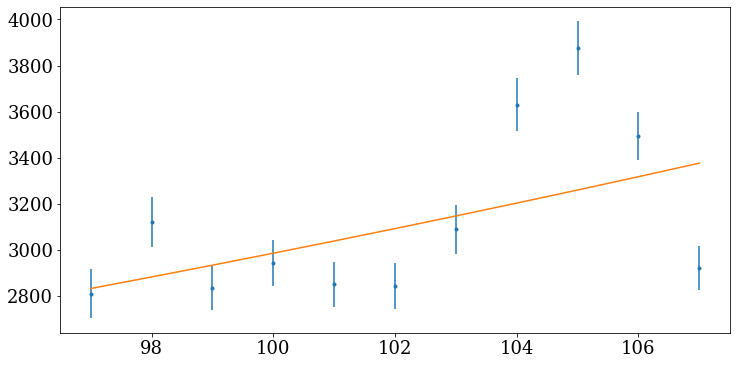

Day 103 is not valid!
Prob(Chi2=168.2, Ndof= 9) = 0.000
Rt fit = 0.993 +- 0.014
S0 fit = 3030.306 +- 30.745 with start value 3087.349


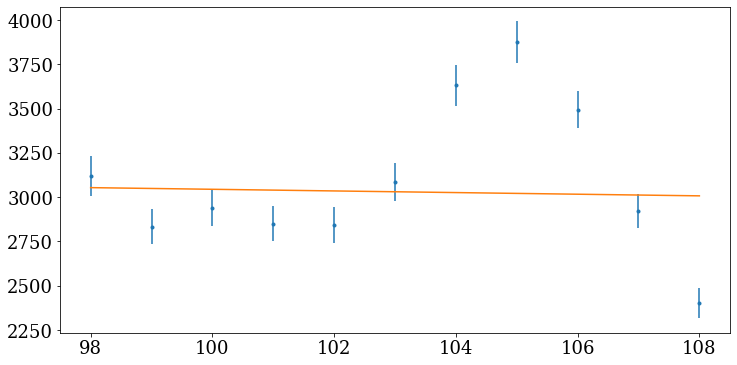

Day 104 is not valid!
Prob(Chi2=232.7, Ndof= 9) = 0.000
Rt fit = 0.934 +- 0.013
S0 fit = 2923.053 +- 29.875 with start value 3630.394


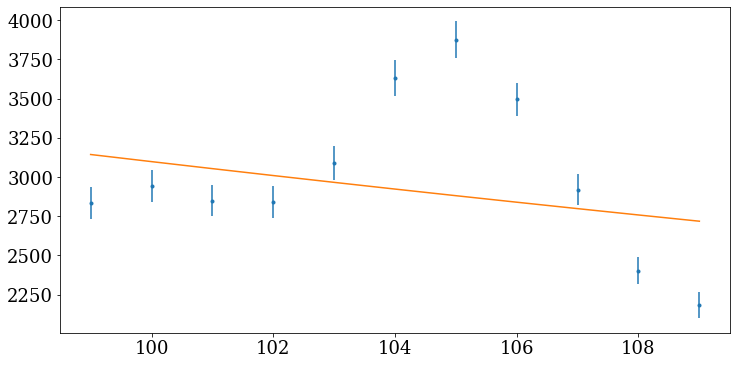

Day 105 is not valid!
Prob(Chi2=255.9, Ndof= 9) = 0.000
Rt fit = 0.866 +- 0.012
S0 fit = 2835.818 +- 29.349 with start value 3874.687


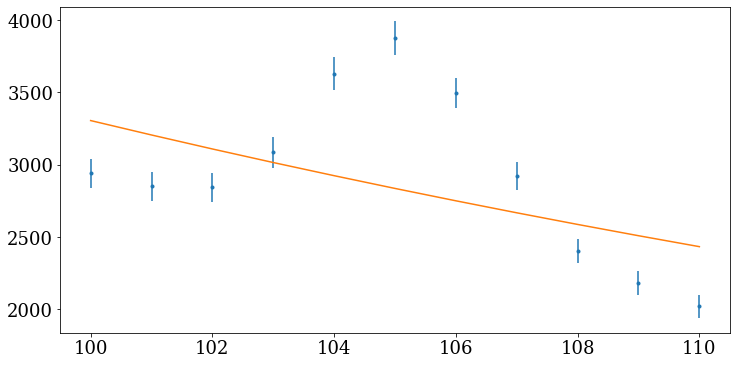

Day 106 is not valid!
Prob(Chi2=238.0, Ndof= 9) = 0.000
Rt fit = 0.843 +- 0.012
S0 fit = 2789.950 +- 28.951 with start value 3494.380


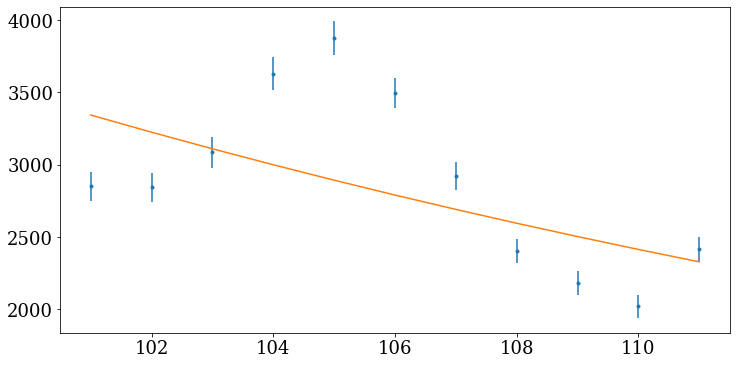

Day 107 is not valid!
Prob(Chi2=201.5, Ndof= 9) = 0.000
Rt fit = 0.809 +- 0.012
S0 fit = 2749.152 +- 28.716 with start value 2920.025


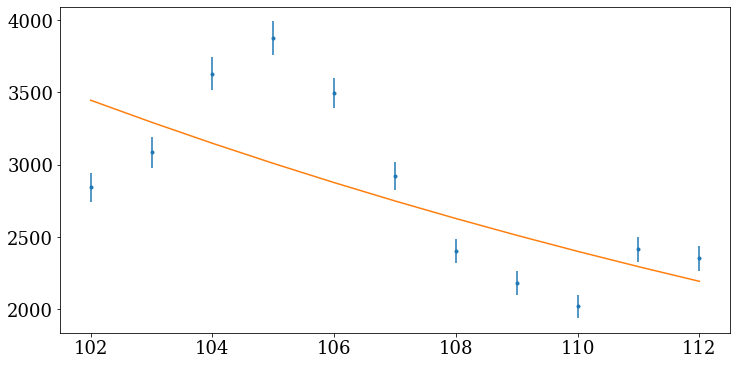

Day 108 is not valid!
Prob(Chi2=179.3, Ndof= 9) = 0.000
Rt fit = 0.783 +- 0.013
S0 fit = 2723.650 +- 28.566 with start value 2402.986


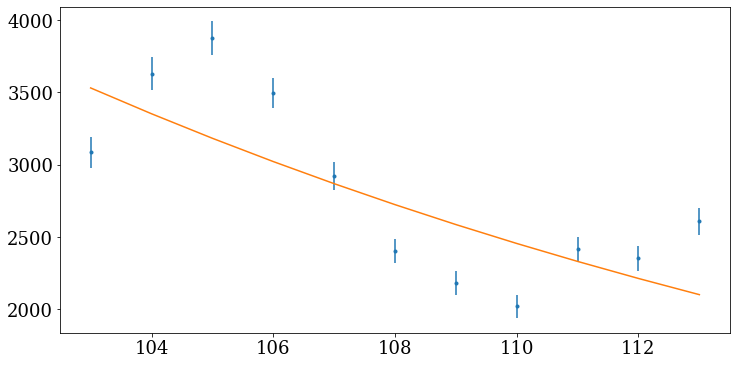

Day 109 is not valid!
Prob(Chi2=158.8, Ndof= 9) = 0.000
Rt fit = 0.753 +- 0.014
S0 fit = 2625.016 +- 28.879 with start value 2183.697


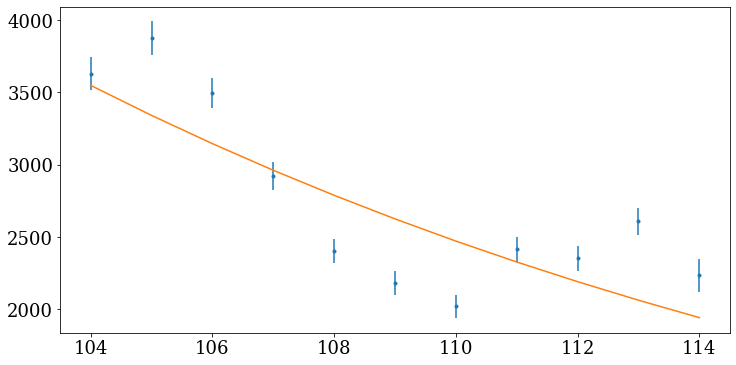

Day 110 is not valid!
Prob(Chi2=167.6, Ndof= 9) = 0.000
Rt fit = 0.786 +- 0.016
S0 fit = 2503.867 +- 29.013 with start value 2020.103


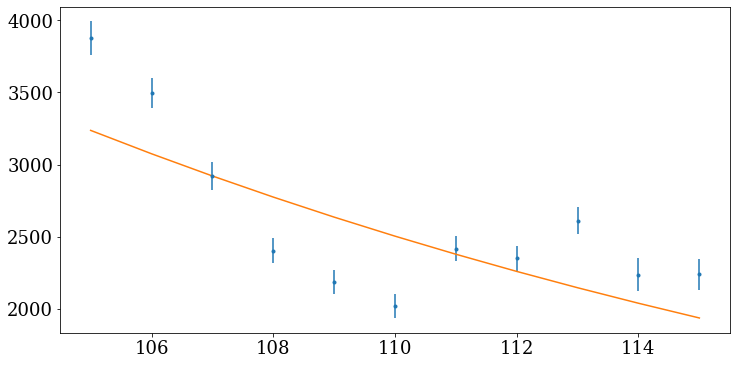

Day 111 is not valid!
Prob(Chi2=173.1, Ndof= 9) = 0.000
Rt fit = 0.919 +- 0.018
S0 fit = 2463.792 +- 28.665 with start value 2415.910


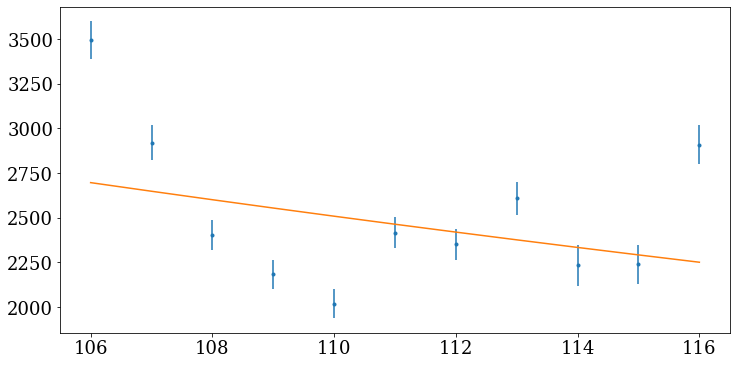

Day 112 is not valid!
Prob(Chi2= 88.9, Ndof= 9) = 0.000
Rt fit = 1.014 +- 0.019
S0 fit = 2408.521 +- 28.499 with start value 2351.033


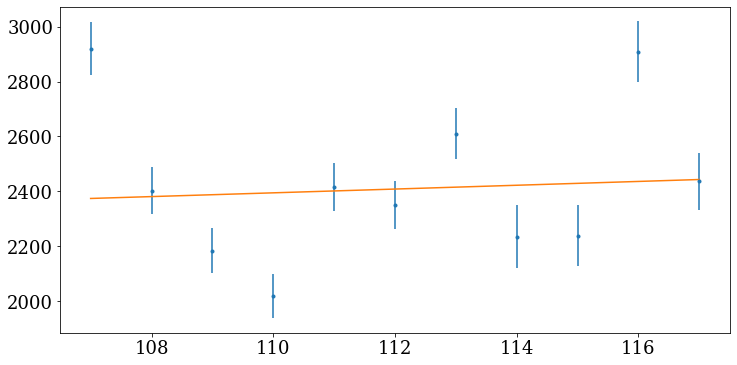

Day 113 is not valid!
Prob(Chi2= 51.7, Ndof= 9) = 0.000
Rt fit = 1.110 +- 0.019
S0 fit = 2428.410 +- 28.639 with start value 2609.467


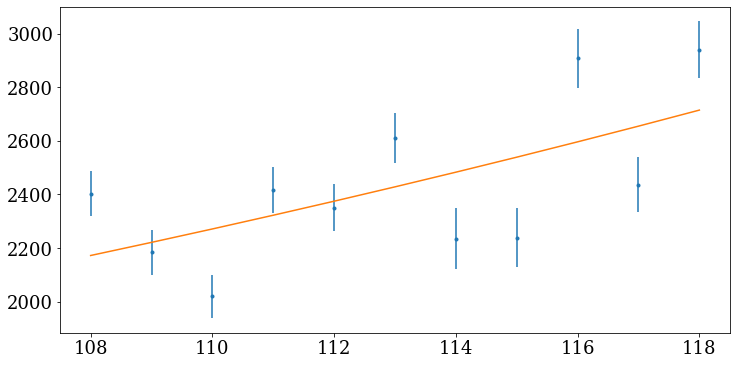

Day 114 is not valid!
Prob(Chi2= 54.6, Ndof= 9) = 0.000
Rt fit = 1.100 +- 0.018
S0 fit = 2421.824 +- 28.860 with start value 2234.860


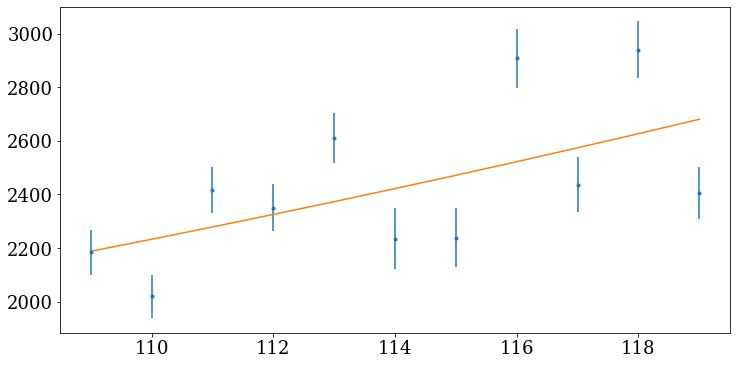

Day 115 is not valid!
Prob(Chi2= 60.2, Ndof= 9) = 0.000
Rt fit = 1.073 +- 0.017
S0 fit = 2442.529 +- 29.087 with start value 2238.763


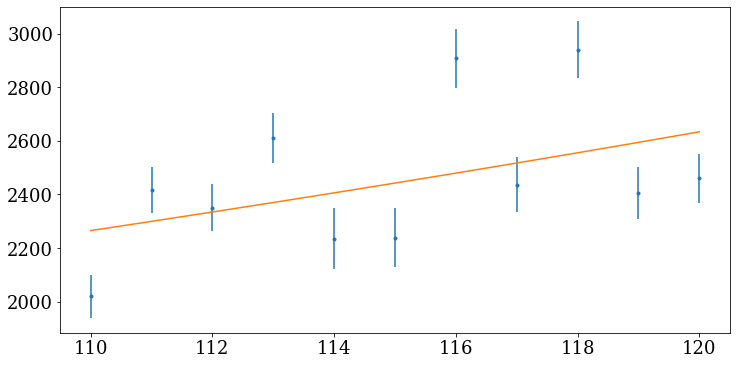

Day 116 is not valid!
Prob(Chi2= 67.7, Ndof= 9) = 0.000
Rt fit = 0.995 +- 0.017
S0 fit = 2456.380 +- 30.037 with start value 2908.795


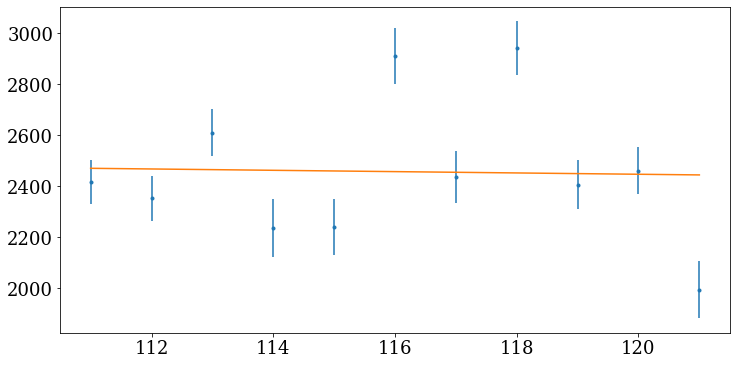

Day 117 is not valid!
Prob(Chi2= 85.1, Ndof= 9) = 0.000
Rt fit = 0.949 +- 0.017
S0 fit = 2410.522 +- 30.706 with start value 2436.343


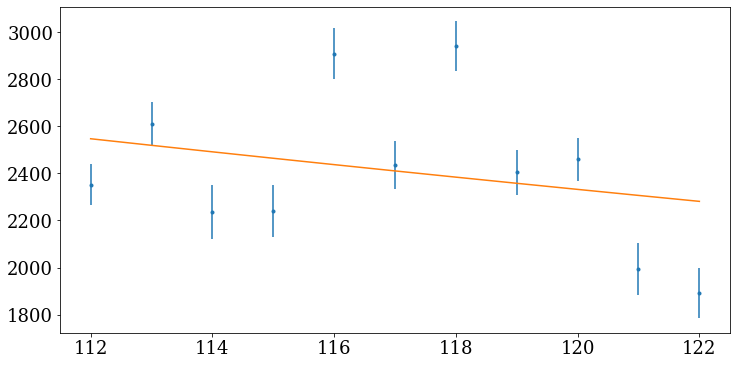

Day 118 is not valid!
Prob(Chi2= 78.4, Ndof= 9) = 0.000
Rt fit = 0.904 +- 0.016
S0 fit = 2383.065 +- 30.743 with start value 2940.579


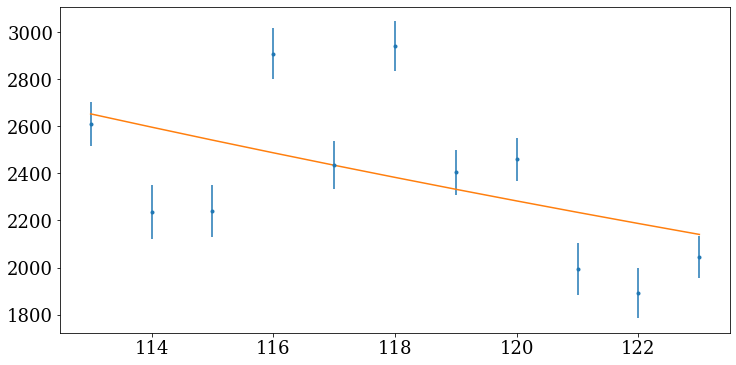

Day 119 is not valid!
Prob(Chi2= 81.3, Ndof= 9) = 0.000
Rt fit = 0.880 +- 0.017
S0 fit = 2315.288 +- 30.723 with start value 2405.097


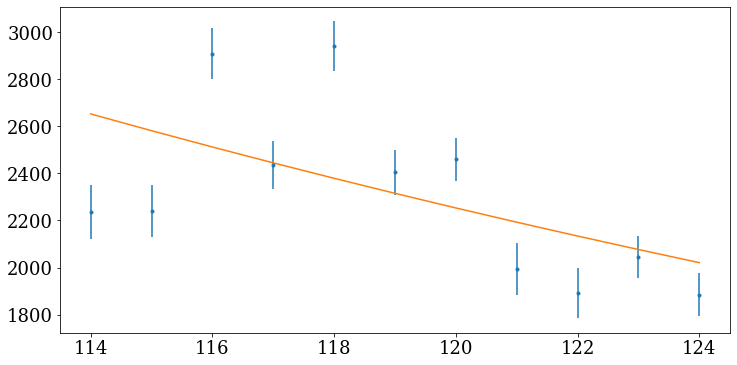

Day 120 is not valid!
Prob(Chi2= 85.5, Ndof= 9) = 0.000
Rt fit = 0.882 +- 0.017
S0 fit = 2327.688 +- 30.280 with start value 2459.802


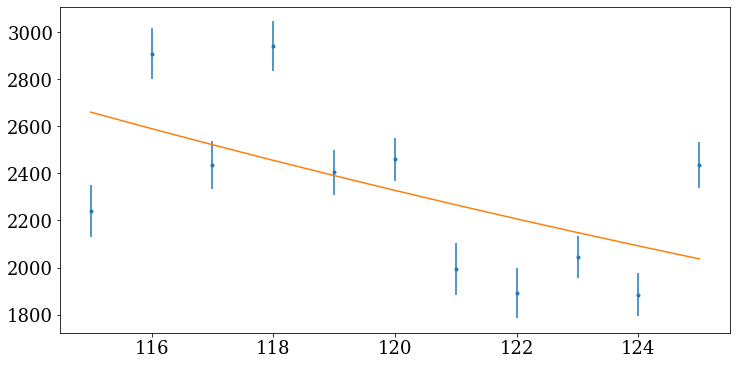

Day 121 is not valid!
Prob(Chi2= 64.2, Ndof= 9) = 0.000
Rt fit = 0.844 +- 0.017
S0 fit = 2295.975 +- 29.815 with start value 1993.901


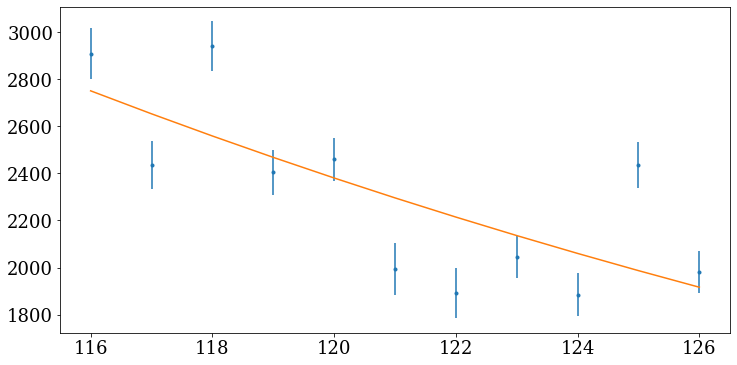

Day 122 is not valid!
Prob(Chi2= 71.6, Ndof= 9) = 0.000
Rt fit = 0.827 +- 0.016
S0 fit = 2166.059 +- 28.787 with start value 1892.811


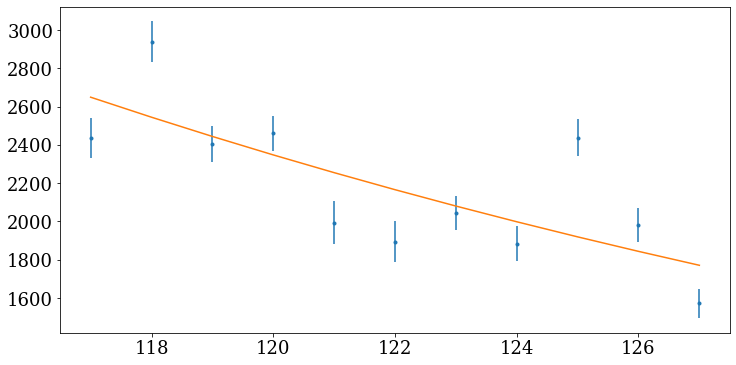

Day 123 is not valid!
Prob(Chi2= 65.1, Ndof= 9) = 0.000
Rt fit = 0.799 +- 0.016
S0 fit = 2086.406 +- 28.211 with start value 2044.148


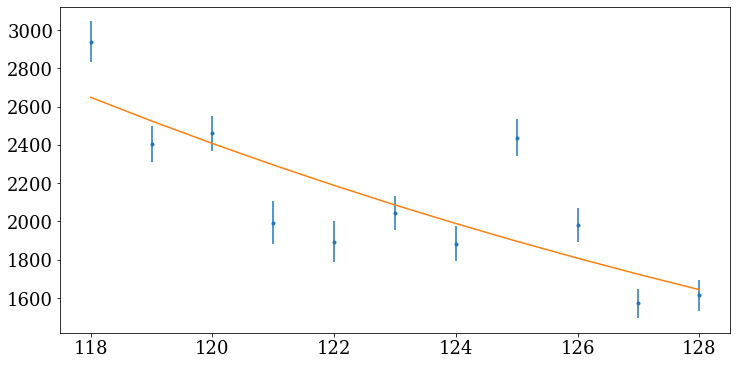

Day 124 is not valid!
Prob(Chi2= 57.1, Ndof= 9) = 0.000
Rt fit = 0.813 +- 0.016
S0 fit = 1953.900 +- 27.306 with start value 1883.927


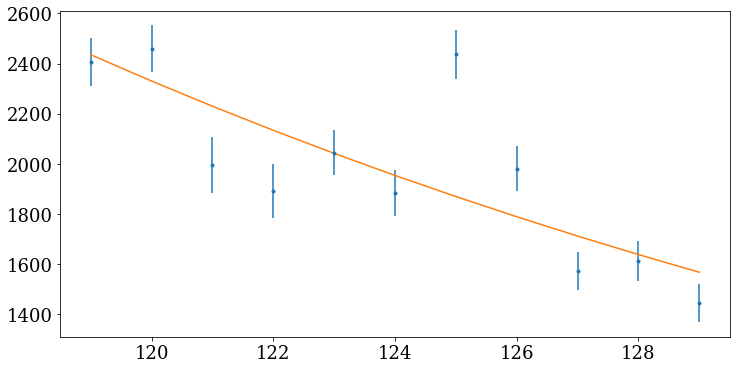

Day 125 is not valid!
Prob(Chi2= 57.9, Ndof= 9) = 0.000
Rt fit = 0.801 +- 0.017
S0 fit = 1862.432 +- 26.897 with start value 2436.749


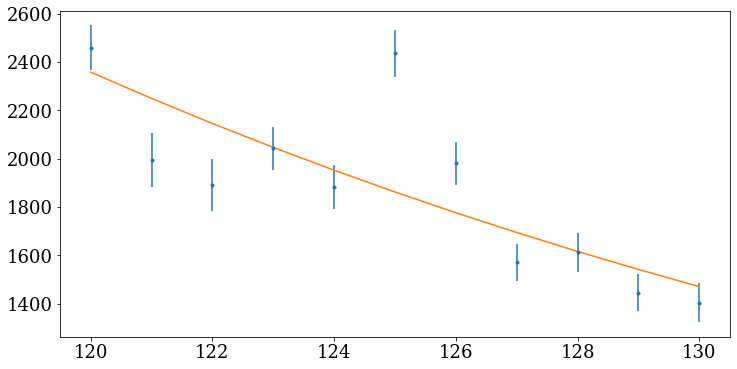

Day 126 is not valid!
Prob(Chi2= 57.6, Ndof= 9) = 0.000
Rt fit = 0.805 +- 0.018
S0 fit = 1757.560 +- 26.591 with start value 1980.852


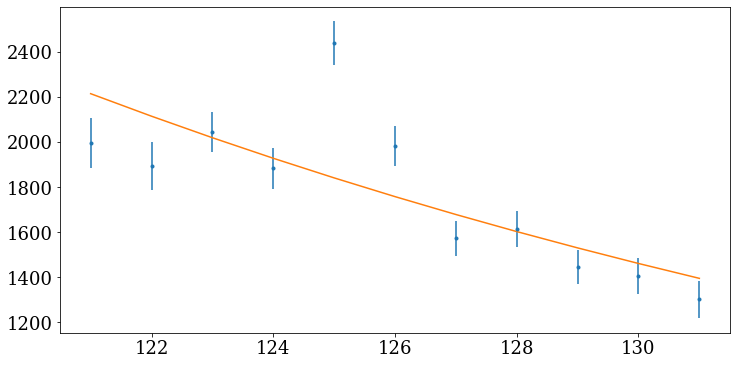

Day 127 is not valid!
Prob(Chi2= 57.4, Ndof= 9) = 0.000
Rt fit = 0.803 +- 0.019
S0 fit = 1707.587 +- 25.936 with start value 1572.103


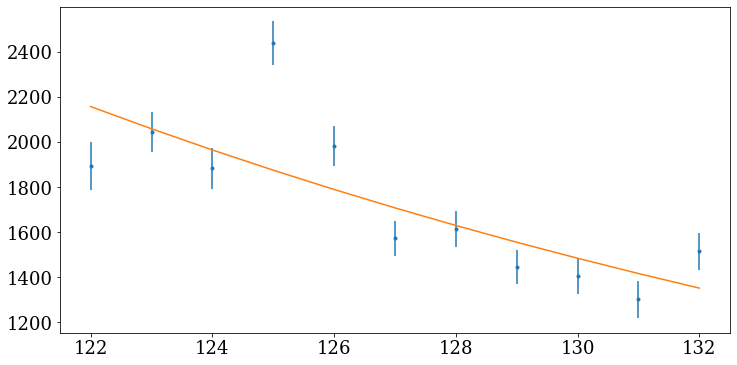

Day 128 is not valid!
Prob(Chi2= 52.7, Ndof= 9) = 0.000
Rt fit = 0.793 +- 0.019
S0 fit = 1656.513 +- 25.468 with start value 1613.440


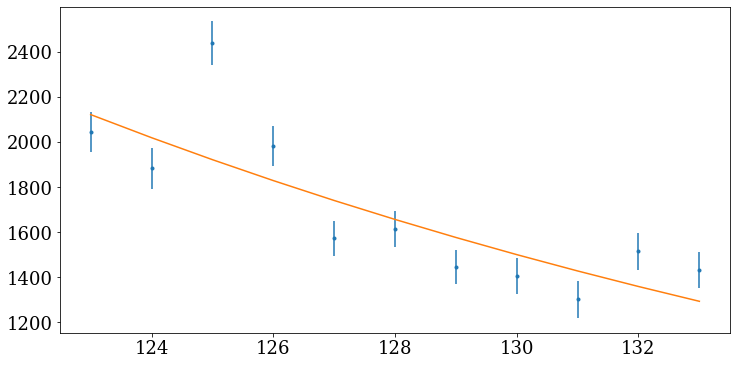

Day 129 is not valid!
Prob(Chi2= 51.6, Ndof= 9) = 0.000
Rt fit = 0.775 +- 0.019
S0 fit = 1574.588 +- 24.918 with start value 1444.968


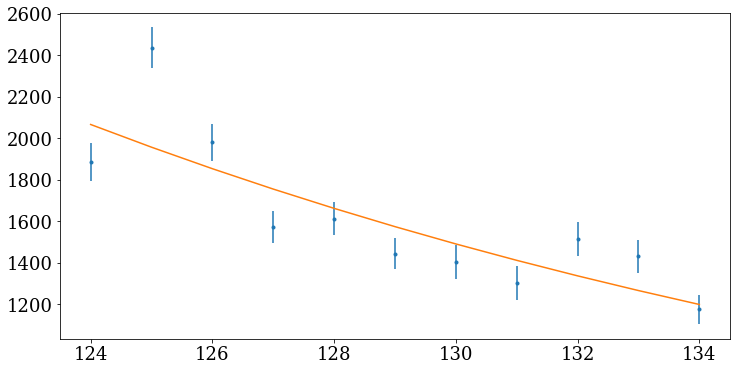

Day 130 is not valid!
Prob(Chi2= 50.8, Ndof= 9) = 0.000
Rt fit = 0.716 +- 0.017
S0 fit = 1466.532 +- 23.950 with start value 1404.624


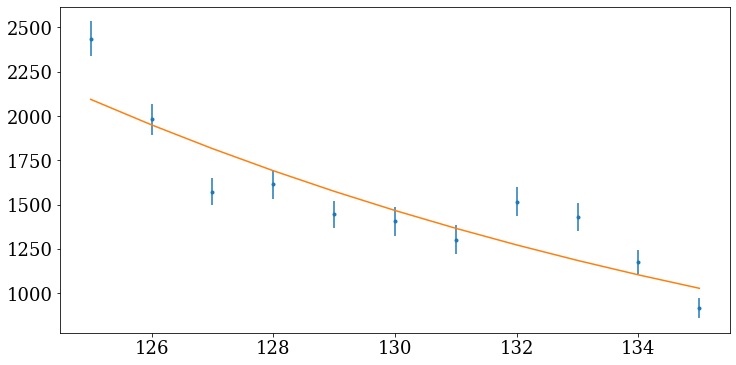

Day 131 is not valid!
Prob(Chi2= 48.8, Ndof= 9) = 0.000
Rt fit = 0.713 +- 0.017
S0 fit = 1311.504 +- 22.363 with start value 1301.749


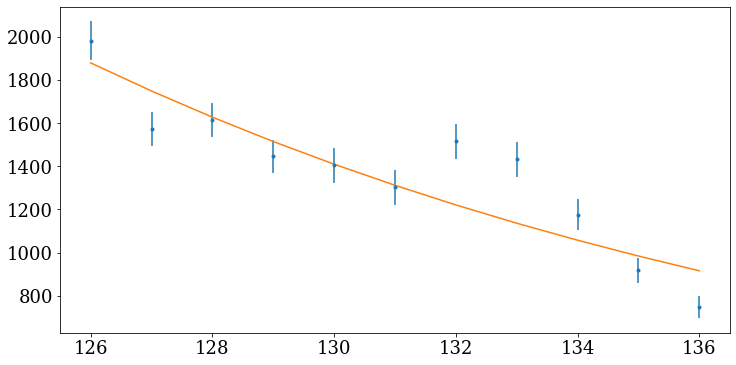

Day 132 is not valid!
Prob(Chi2= 54.3, Ndof= 9) = 0.000
Rt fit = 0.702 +- 0.017
S0 fit = 1191.662 +- 21.240 with start value 1515.341


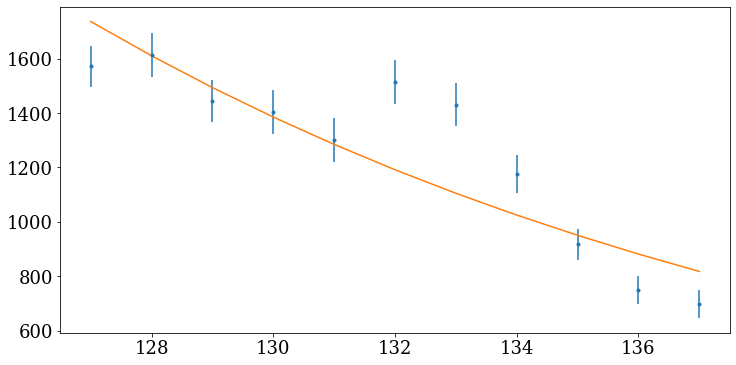

Day 133 is not valid!
Prob(Chi2= 46.7, Ndof= 9) = 0.000
Rt fit = 0.670 +- 0.017
S0 fit = 1112.167 +- 20.661 with start value 1431.184


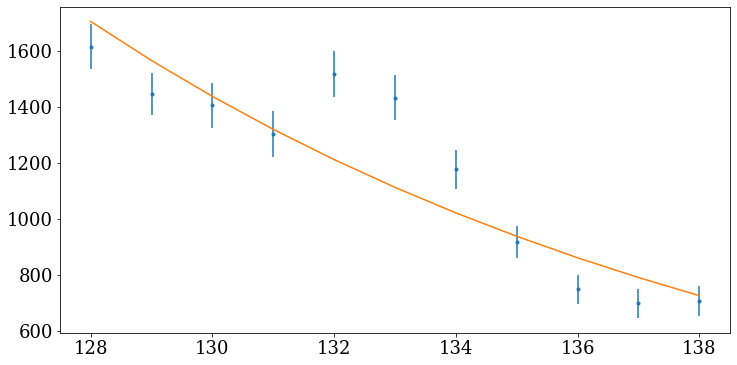

Day 134 is not valid!
Prob(Chi2= 58.1, Ndof= 9) = 0.000
Rt fit = 0.683 +- 0.019
S0 fit = 1049.894 +- 20.015 with start value 1176.040


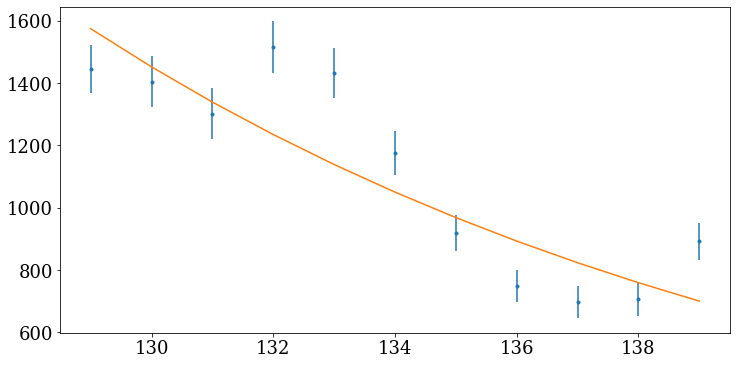

Day 135 is not valid!
Prob(Chi2= 67.2, Ndof= 9) = 0.000
Rt fit = 0.690 +- 0.021
S0 fit = 999.114 +- 19.473 with start value 917.351


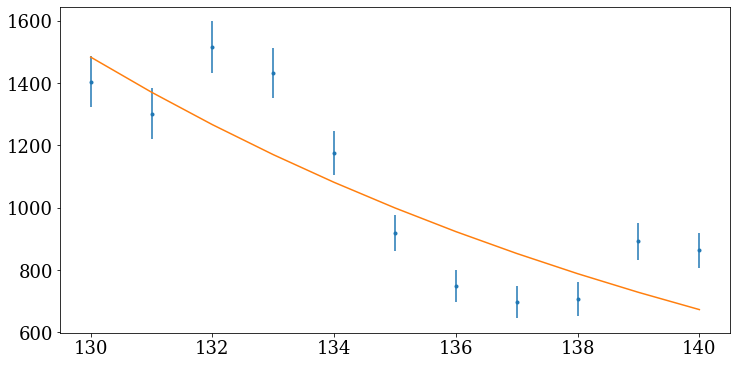

Day 136 is not valid!
Prob(Chi2= 67.0, Ndof= 9) = 0.000
Rt fit = 0.686 +- 0.022
S0 fit = 934.090 +- 18.599 with start value 748.099


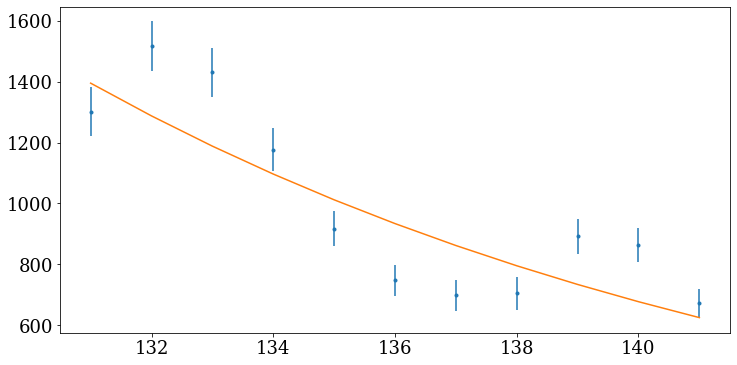

Day 137 is not valid!
Prob(Chi2= 72.2, Ndof= 9) = 0.000
Rt fit = 0.701 +- 0.024
S0 fit = 883.016 +- 17.781 with start value 698.084


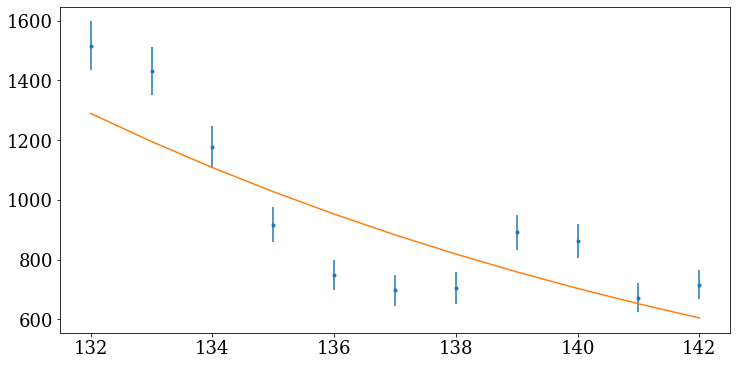

Day 138 is not valid!
Prob(Chi2= 60.7, Ndof= 9) = 0.000
Rt fit = 0.748 +- 0.025
S0 fit = 813.713 +- 16.748 with start value 705.804


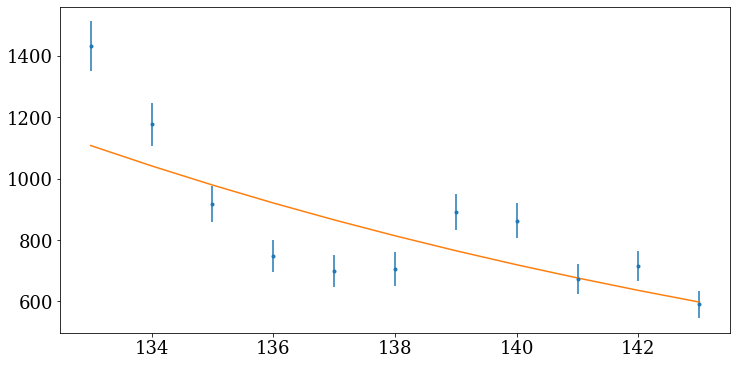

Day 139 is not valid!
Prob(Chi2= 39.2, Ndof= 9) = 0.000
Rt fit = 0.797 +- 0.025
S0 fit = 752.115 +- 15.939 with start value 892.043


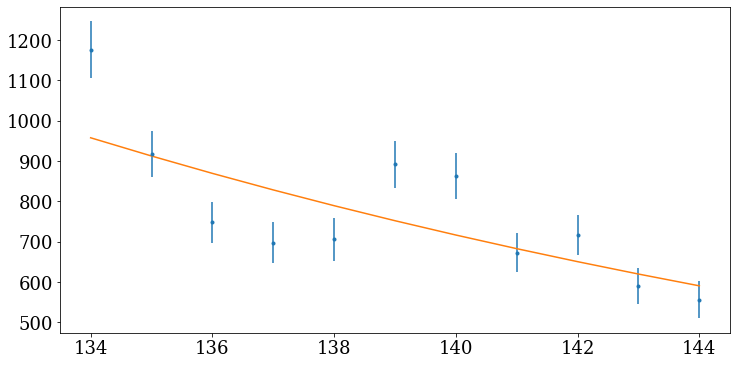

Day 141 is not valid!
Prob(Chi2= 29.0, Ndof= 9) = 0.001
Rt fit = 0.865 +- 0.028
S0 fit = 679.924 +- 15.100 with start value 672.509


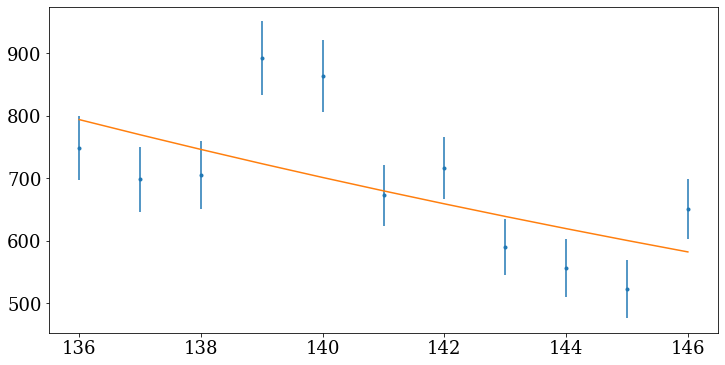

Day 142 is not valid!
Prob(Chi2= 30.3, Ndof= 9) = 0.000
Rt fit = 0.868 +- 0.029
S0 fit = 670.425 +- 15.048 with start value 716.338


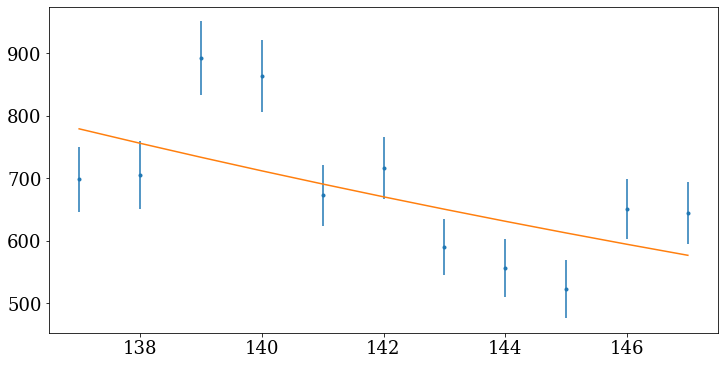

Day 143 is not valid!
Prob(Chi2= 28.9, Ndof= 9) = 0.001
Rt fit = 0.802 +- 0.027
S0 fit = 644.882 +- 14.719 with start value 590.290


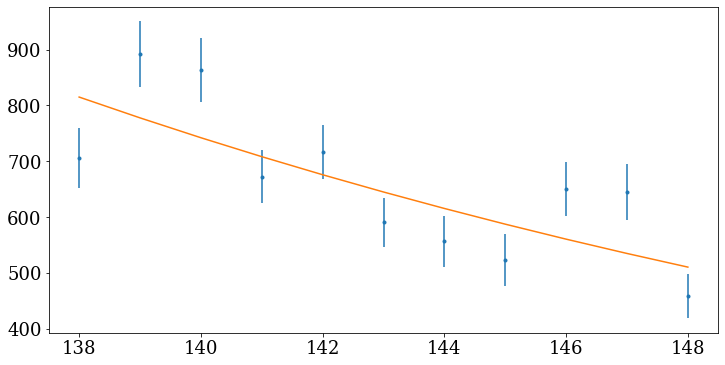

Day 145 is not valid!
Prob(Chi2= 28.6, Ndof= 9) = 0.001
Rt fit = 0.714 +- 0.025
S0 fit = 556.788 +- 13.493 with start value 522.903


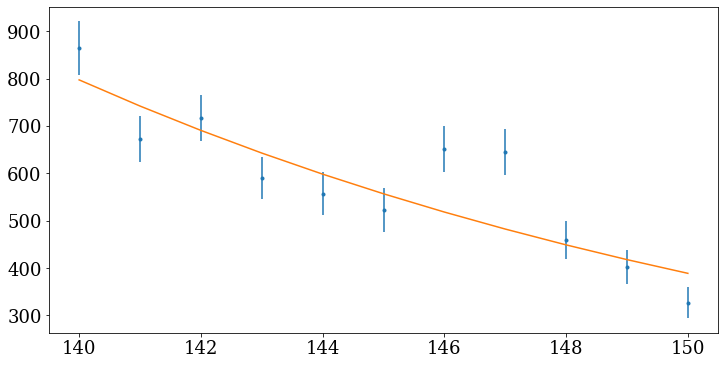

Day 148 is not valid!
Prob(Chi2= 35.3, Ndof= 9) = 0.000
Rt fit = 0.767 +- 0.031
S0 fit = 464.216 +- 12.440 with start value 458.830


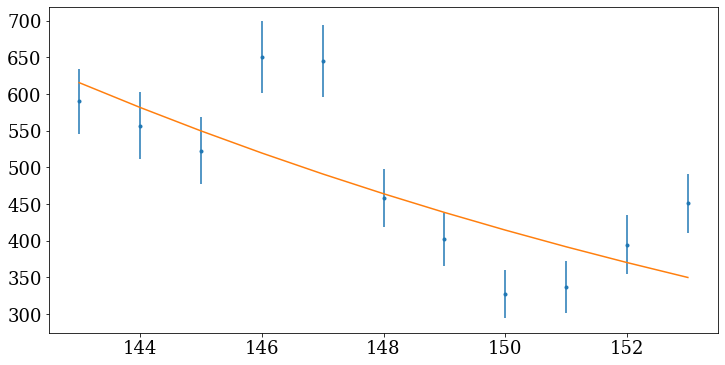

Day 149 is not valid!
Prob(Chi2= 43.7, Ndof= 9) = 0.000
Rt fit = 0.799 +- 0.035
S0 fit = 452.132 +- 12.348 with start value 401.797


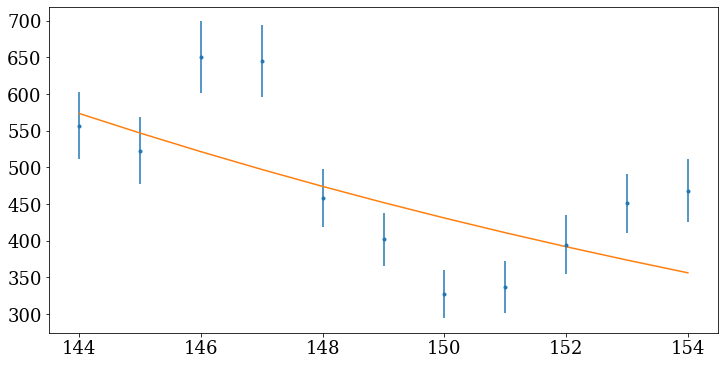

Day 150 is not valid!
Prob(Chi2= 44.1, Ndof= 9) = 0.000
Rt fit = 0.807 +- 0.037
S0 fit = 435.773 +- 12.082 with start value 327.382


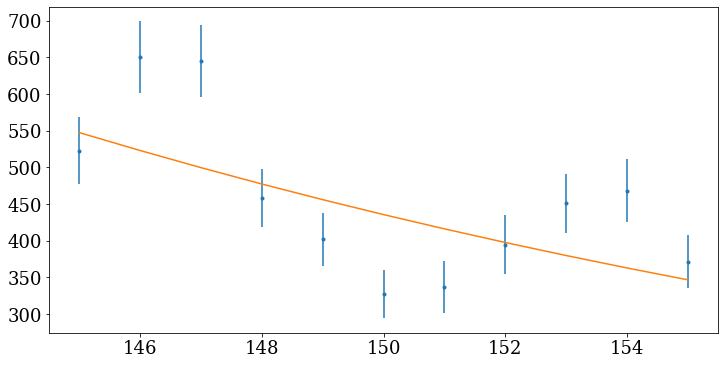

Day 151 is not valid!
Prob(Chi2= 43.9, Ndof= 9) = 0.000
Rt fit = 0.800 +- 0.037
S0 fit = 419.100 +- 11.713 with start value 336.769


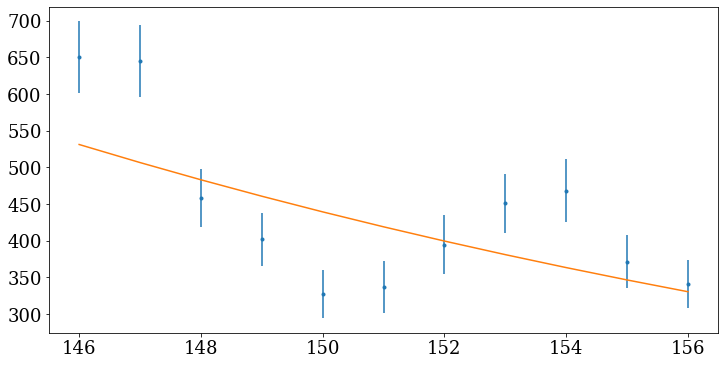

Day 152 is not valid!
Prob(Chi2= 35.5, Ndof= 9) = 0.000
Rt fit = 0.847 +- 0.037
S0 fit = 393.133 +- 11.198 with start value 394.859


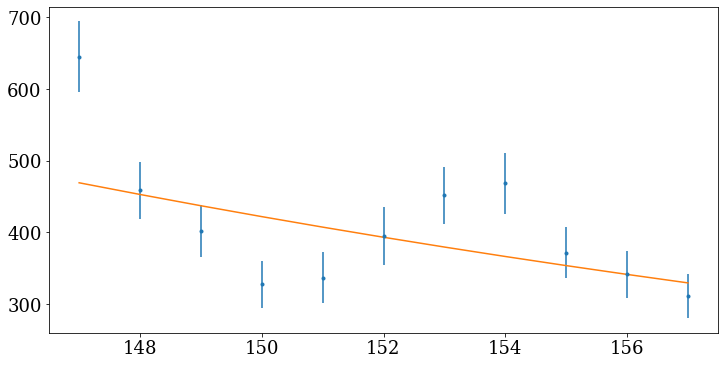

Day 163 is not valid!
Prob(Chi2= 41.9, Ndof= 9) = 0.000
Rt fit = 0.935 +- 0.049
S0 fit = 346.776 +- 10.627 with start value 282.861


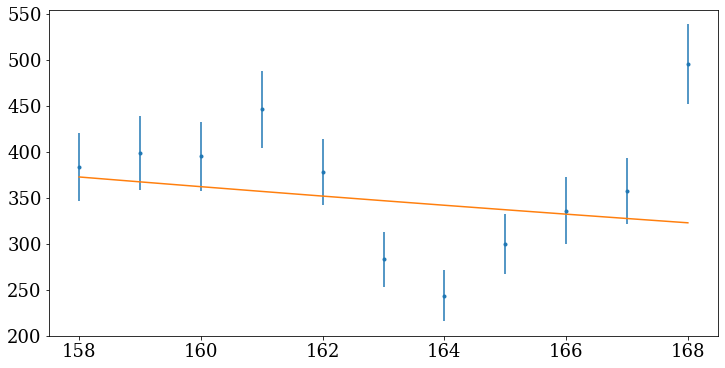

Day 164 is not valid!
Prob(Chi2= 46.6, Ndof= 9) = 0.000
Rt fit = 1.026 +- 0.056
S0 fit = 349.714 +- 10.641 with start value 243.454


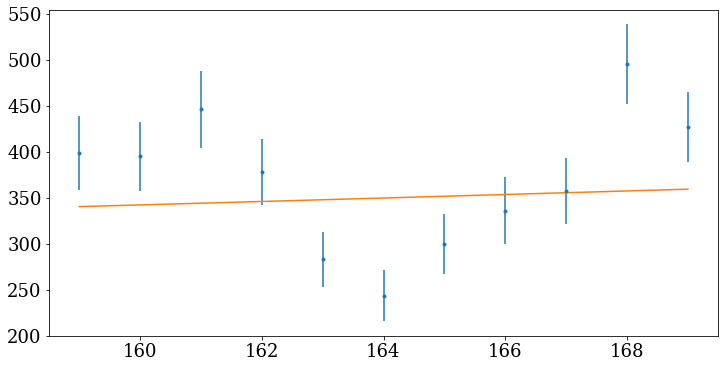

Day 165 is not valid!
Prob(Chi2= 44.2, Ndof= 9) = 0.000
Rt fit = 1.114 +- 0.056
S0 fit = 352.309 +- 10.567 with start value 299.598


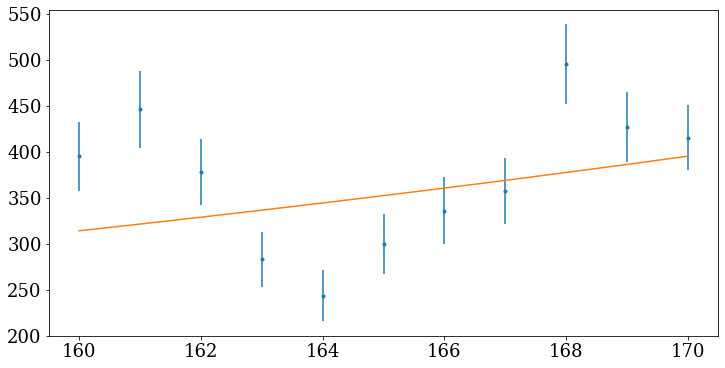

Day 166 is not valid!
Prob(Chi2= 40.5, Ndof= 9) = 0.000
Rt fit = 1.129 +- 0.052
S0 fit = 349.635 +- 10.461 with start value 335.683


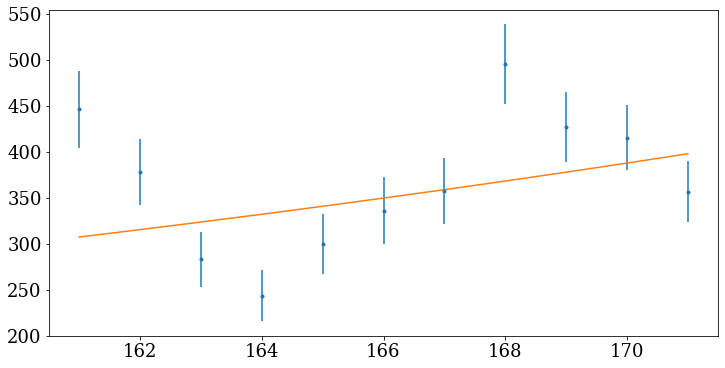

Day 167 is not valid!
Prob(Chi2= 28.5, Ndof= 9) = 0.001
Rt fit = 1.172 +- 0.050
S0 fit = 347.692 +- 10.373 with start value 356.926


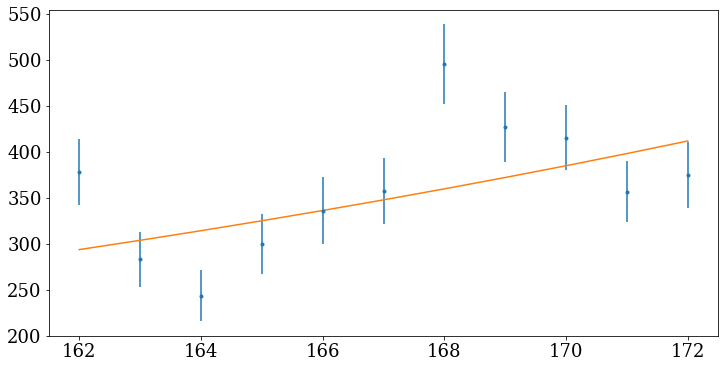

Day 176 is not valid!
Prob(Chi2= 28.2, Ndof= 9) = 0.001
Rt fit = 0.992 +- 0.039
S0 fit = 404.831 +- 10.932 with start value 433.213


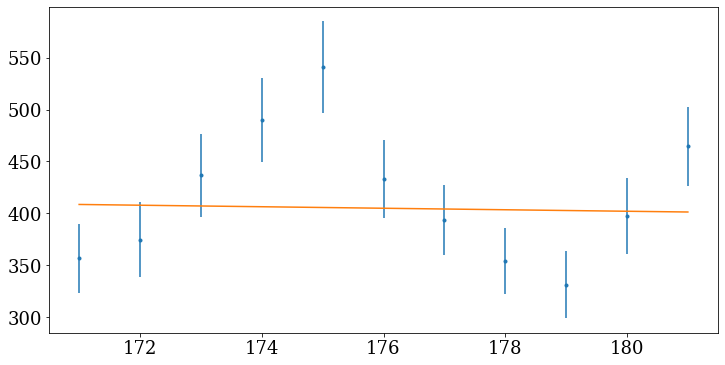

Day 177 is not valid!
Prob(Chi2= 30.1, Ndof= 9) = 0.000
Rt fit = 0.991 +- 0.042
S0 fit = 417.072 +- 11.133 with start value 393.479


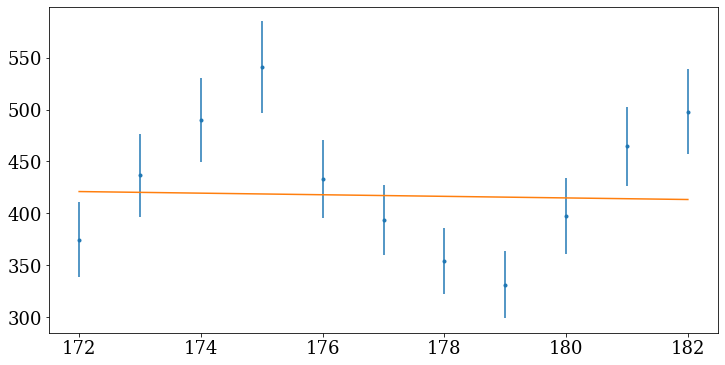

Day 179 is not valid!
Prob(Chi2= 29.7, Ndof= 9) = 0.000
Rt fit = 0.907 +- 0.037
S0 fit = 409.764 +- 10.822 with start value 331.250


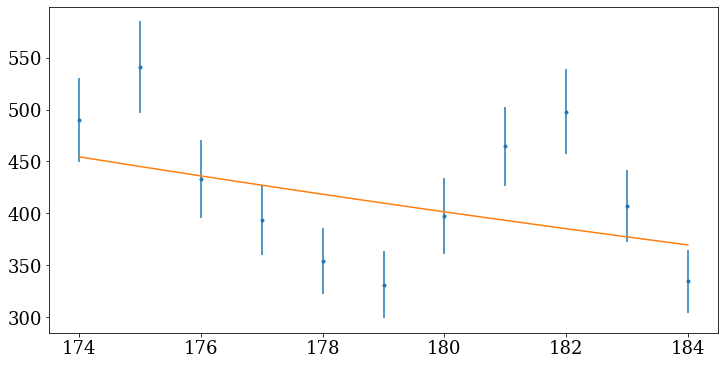

Day 180 is not valid!
Prob(Chi2= 29.6, Ndof= 9) = 0.001
Rt fit = 0.907 +- 0.036
S0 fit = 395.443 +- 10.551 with start value 397.775


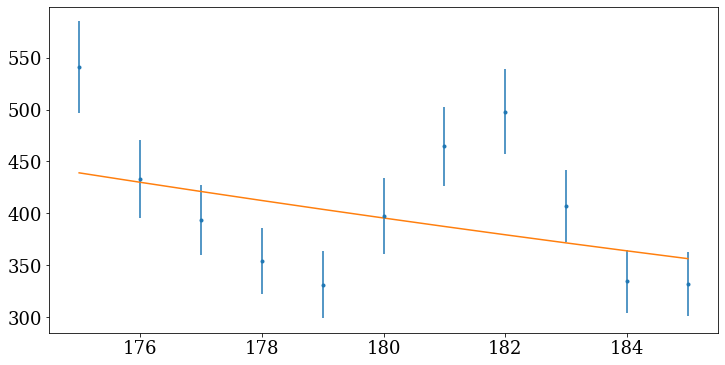

Day 184 is not valid!
Prob(Chi2= 36.2, Ndof= 9) = 0.000
Rt fit = 1.073 +- 0.046
S0 fit = 396.715 +- 10.649 with start value 334.389


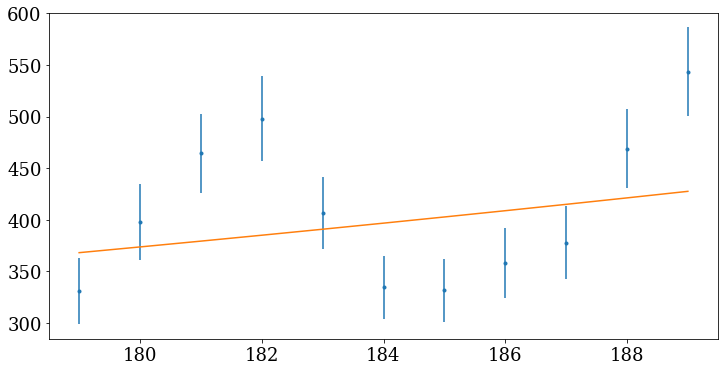

Day 185 is not valid!
Prob(Chi2= 34.0, Ndof= 9) = 0.000
Rt fit = 1.022 +- 0.044
S0 fit = 404.804 +- 10.738 with start value 331.503


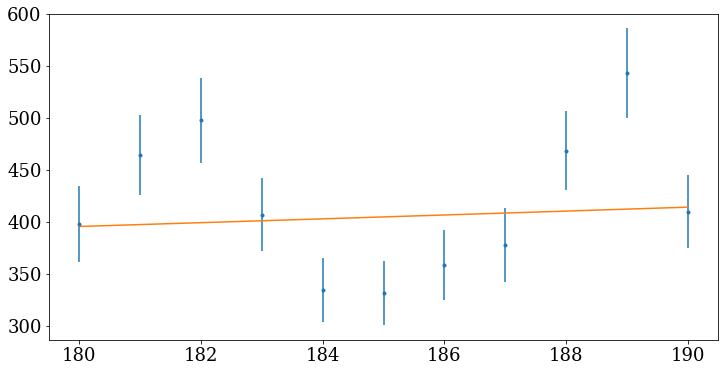

Day 186 is not valid!
Prob(Chi2= 34.1, Ndof= 9) = 0.000
Rt fit = 1.015 +- 0.042
S0 fit = 405.243 +- 10.650 with start value 358.405


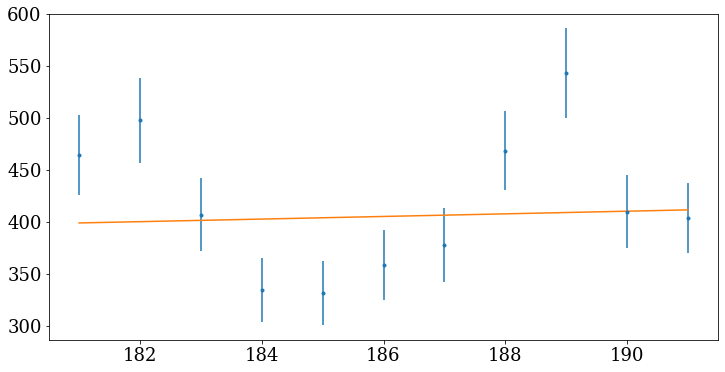

Day 187 is not valid!
Prob(Chi2= 35.5, Ndof= 9) = 0.000
Rt fit = 0.997 +- 0.039
S0 fit = 392.888 +- 10.429 with start value 377.918


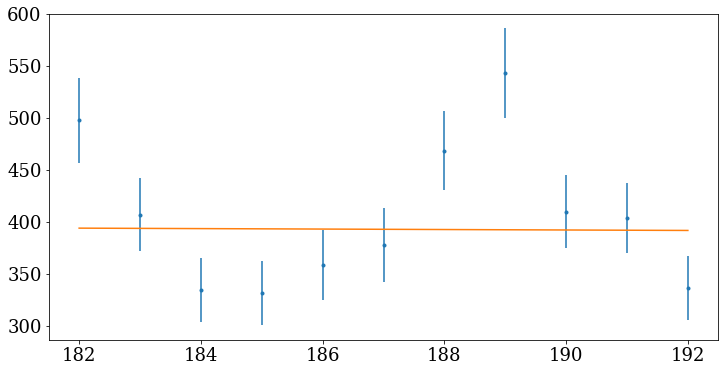

Day 188 is not valid!
Prob(Chi2= 29.5, Ndof= 9) = 0.001
Rt fit = 1.016 +- 0.038
S0 fit = 381.754 +- 10.231 with start value 468.672


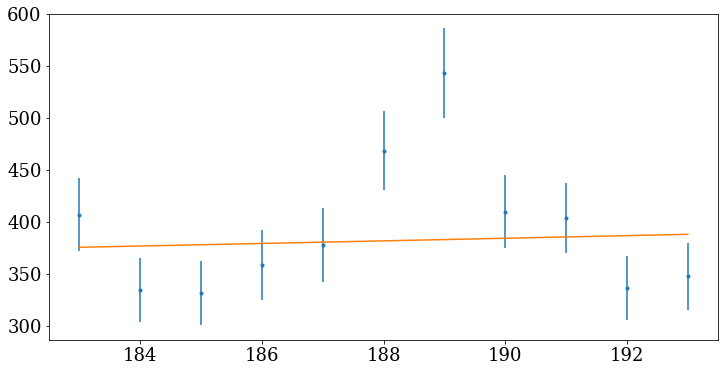

Day 189 is not valid!
Prob(Chi2= 28.5, Ndof= 9) = 0.001
Rt fit = 1.030 +- 0.038
S0 fit = 380.002 +- 10.230 with start value 543.222


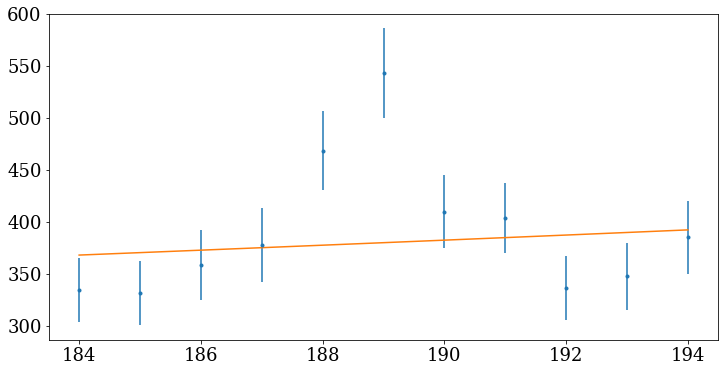

Day 190 is not valid!
Prob(Chi2= 30.9, Ndof= 9) = 0.000
Rt fit = 1.040 +- 0.040
S0 fit = 392.566 +- 10.438 with start value 409.749


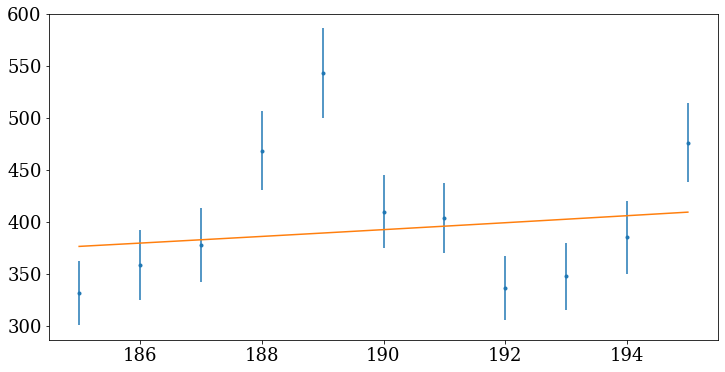

Day 191 is not valid!
Prob(Chi2= 42.4, Ndof= 9) = 0.000
Rt fit = 1.073 +- 0.045
S0 fit = 412.078 +- 10.761 with start value 403.585


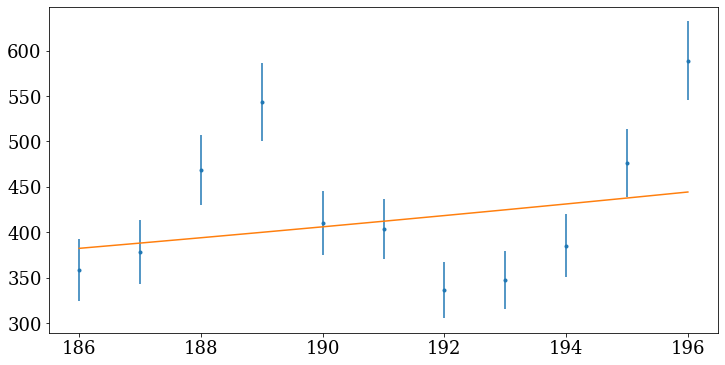

Day 192 is not valid!
Prob(Chi2= 42.4, Ndof= 9) = 0.000
Rt fit = 1.072 +- 0.045
S0 fit = 423.336 +- 10.863 with start value 336.187


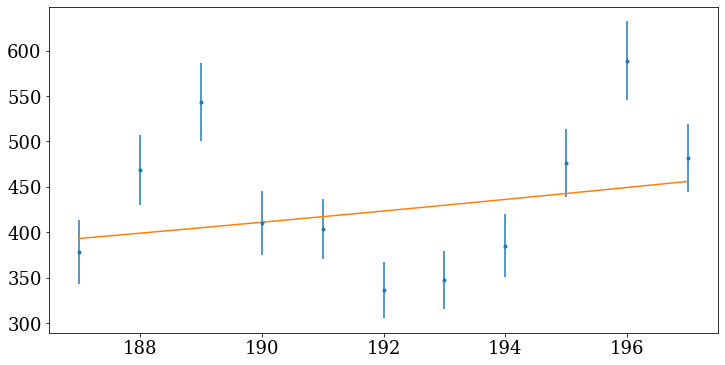

Day 193 is not valid!
Prob(Chi2= 42.2, Ndof= 9) = 0.000
Rt fit = 1.047 +- 0.043
S0 fit = 429.347 +- 10.837 with start value 347.476


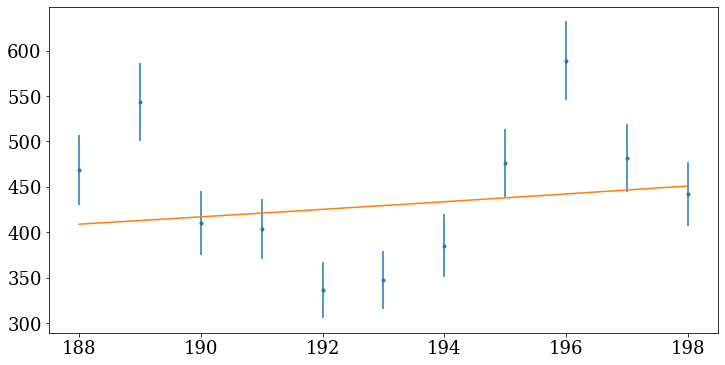

Day 194 is not valid!
Prob(Chi2= 39.2, Ndof= 9) = 0.000
Rt fit = 1.075 +- 0.042
S0 fit = 427.545 +- 10.760 with start value 385.154


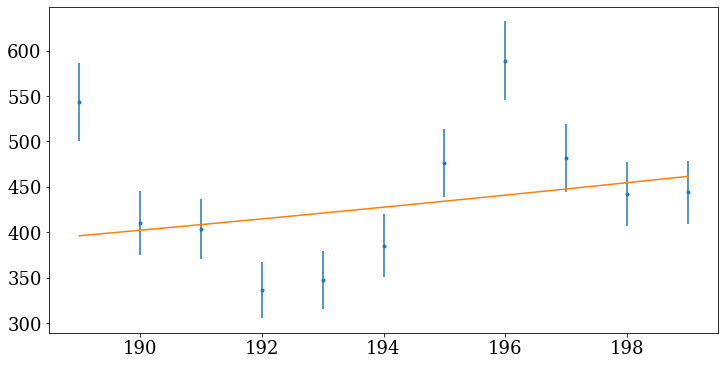

Day 197 is not valid!
Prob(Chi2= 28.8, Ndof= 9) = 0.001
Rt fit = 1.167 +- 0.042
S0 fit = 440.132 +- 10.915 with start value 481.370


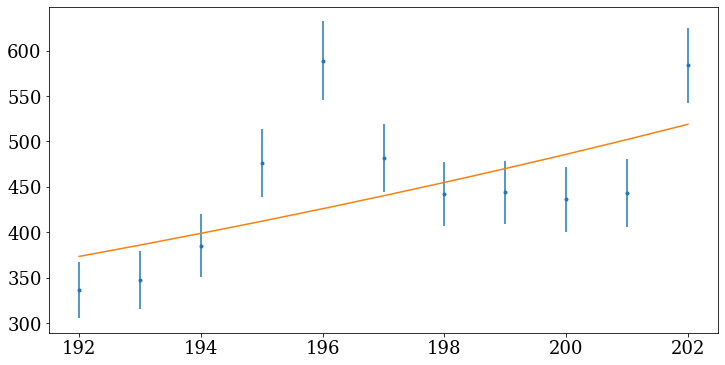

Day 198 is not valid!
Prob(Chi2= 31.1, Ndof= 9) = 0.000
Rt fit = 1.178 +- 0.043
S0 fit = 466.045 +- 11.304 with start value 442.112


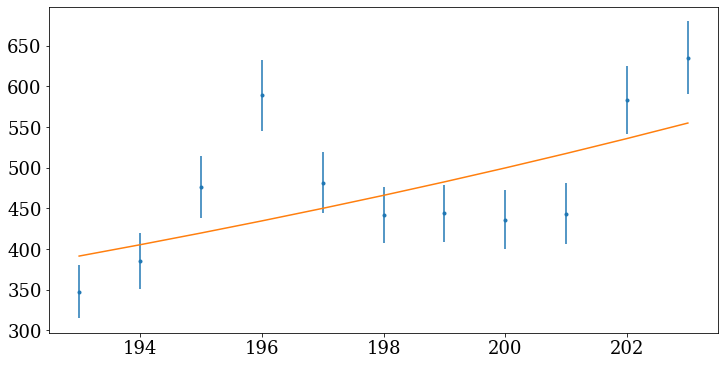

Day 199 is not valid!
Prob(Chi2= 28.3, Ndof= 9) = 0.001
Rt fit = 1.133 +- 0.041
S0 fit = 486.926 +- 11.519 with start value 443.777


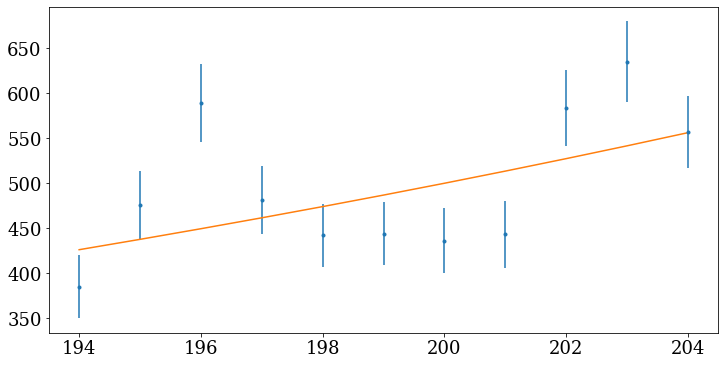

Day 200 is not valid!
Prob(Chi2= 32.8, Ndof= 9) = 0.000
Rt fit = 1.028 +- 0.036
S0 fit = 491.302 +- 11.473 with start value 436.111


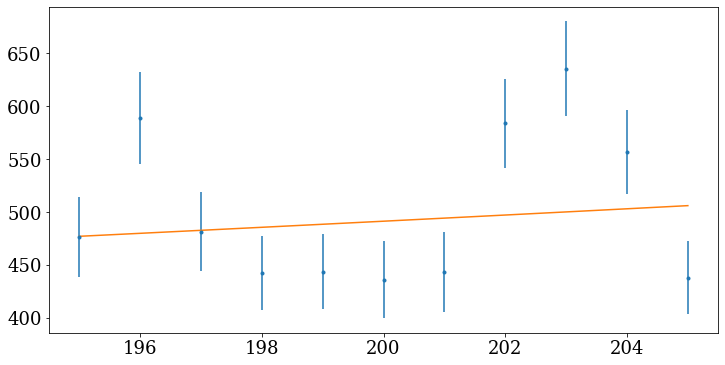

Day 201 is not valid!
Prob(Chi2= 33.6, Ndof= 9) = 0.000
Rt fit = 1.007 +- 0.035
S0 fit = 490.206 +- 11.402 with start value 443.298


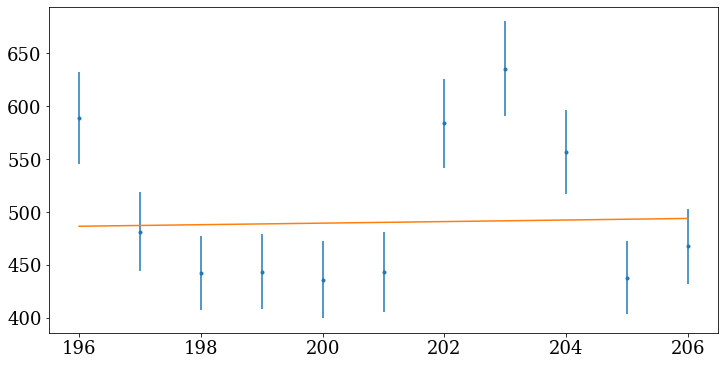

0.3693999505622006


In [15]:
days = np.arange(Plot_EndDay)
R_t, R_t_err = [], [] #R and errors on R
p_fac = []

for i in range(k, Plot_EndDay-k):
    xfit = days[i-k:i+k+1]
    yfit = SCP_all[i-k:i+k+1]
    y_err = eSCP_all[i-k:i+k+1]
    # Exponential function with base Rt:
    def func_Expo(x, S0, Rt, t0, tG) :
    # NOTE: tG = time_generation, i.e. average time between generations.
        return S0 * Rt**((x-t0)/tG)

    # ChiSquare fit model:
    def chi2_calc0(S0, Rt, t0, tG) :
        y_fit = func_Expo(xfit, S0, Rt, t0, tG)
        chi2 = np.sum(((yfit - y_fit) / y_err)**2)
        return chi2

    minuit0 = Minuit(chi2_calc0, S0=SCP_all[i], Rt=1.0, t0=i, fix_t0=True, tG=4.7, fix_tG=True, print_level=0, errordef=1.0)
    minuit0.migrad();                                                  
    
    
    # Here we extract the fitting parameters and their errors
    S0_fit = minuit0.values['S0'];       sigma_S0_fit = minuit0.errors['S0']
    Rt_fit = minuit0.values['Rt'];       sigma_Rt_fit = minuit0.errors['Rt']
    t0_fit = minuit0.values['t0'];       sigma_t0_fit = minuit0.errors['t0']
    tG_fit = minuit0.values['tG'];       sigma_tG_fit = minuit0.errors['tG']
    
    R_t.append(Rt_fit)
    R_t_err.append(sigma_Rt_fit)
    
    # Calcuate fit quality:
    Chi2_fit = minuit0.fval       # The Chi2 value
    Npoints = len(xfit) # Number of points fitted
    Nvar = 2                      # Number of variables (tG is fixed!)
    Ndof_fit = Npoints - Nvar     # Number of degrees of freedom = Number of data points - Number of variables
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom
    p_fac.append(-np.log10(Prob_fit / (1-Prob_fit)))
    #For testing
    #print(f"  Prob(Chi2={Chi2_fit:5.1f}, Ndof={Ndof_fit:2d}) = {Prob_fit:5.3f}")
    #print(f"  Rt fit = {minuit0.values['Rt']:5.3f} +- {minuit0.errors['Rt']:5.3f}")
    if not minuit0.valid or Prob_fit < 0.001:
        print(f"Day {i:d} is not valid!")
        print(f"Prob(Chi2={Chi2_fit:5.1f}, Ndof={Ndof_fit:2d}) = {Prob_fit:5.3f}")
        print(f"Rt fit = {minuit0.values['Rt']:5.3f} +- {minuit0.errors['Rt']:5.3f}")
        print(f"S0 fit = {minuit0.values['S0']:5.3f} +- {minuit0.errors['S0']:5.3f} with start value {SCP_all[i]:5.3f}")
        fig, ax = plt.subplots(figsize=(12,6))
        ax.errorbar(xfit,yfit,yerr=y_err,fmt='.')
        ax.plot(xfit,func_Expo(xfit,S0_fit,Rt_fit,t0_fit,tG_fit))
        plt.show()
print(min(p_fac))

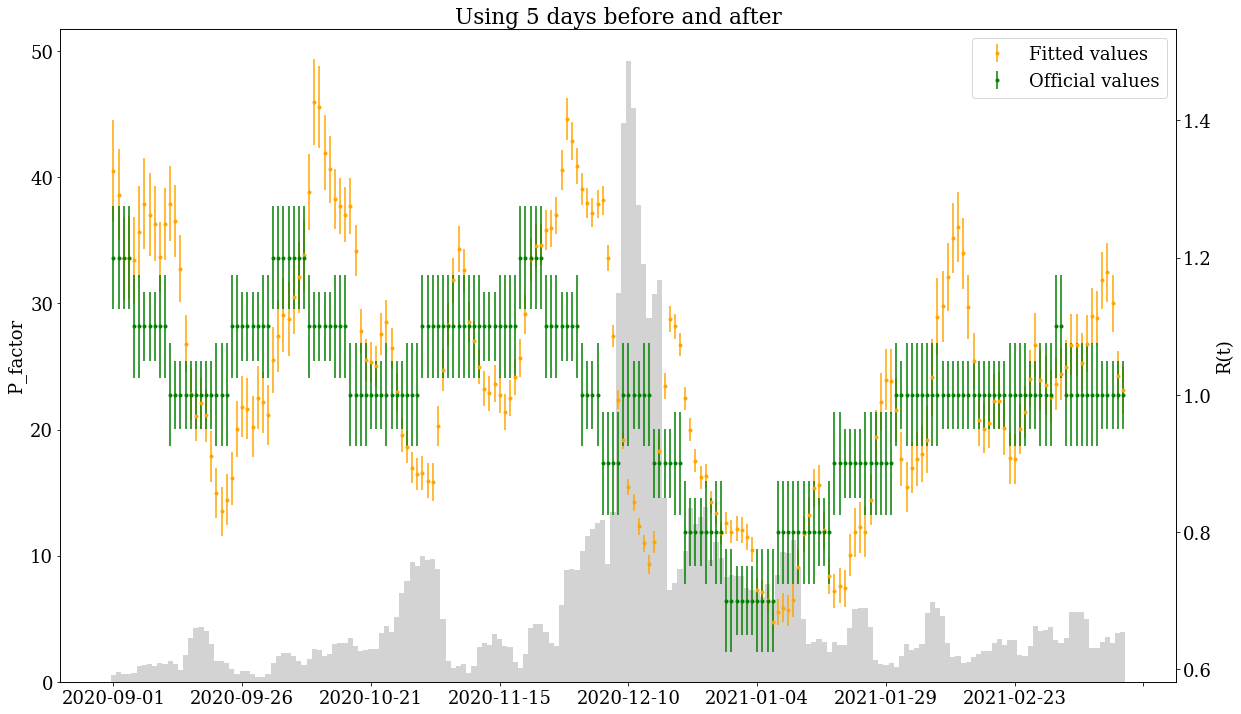

In [16]:
fig, ax2 = plt.subplots(figsize=(20,12))
ax2.bar(P_all[:Plot_EndDay-2*k].index, p_fac, 1.0, color='lightgray')
ax2.set(ylabel="P_factor")
ax = ax2.twinx()
ax.errorbar(P_all[:Plot_EndDay-2*k].index, R_t, yerr=R_t_err, label = "Fitted values",color='orange', fmt='.')
ax.errorbar(P_all[:Plot_EndDay-2*k].index, R_t_central, yerr=R_t_referr, label = "Official values",color='green', fmt='.')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
for label in ax.get_xticklabels():
        label.set_rotation(40)
ax.legend(loc="best")
ax.set(title=f"Using {k:d} days before and after",ylabel="R(t)")


plt.show()